# DISEÑO DE UN CONTROLADOR FUZZY PARA GUIADO DE UN ROBOT MOVIL



*   Brayan Estrada Ramos
*   Dennis Juilland Prada
*   Pablo Mesa Hernandez
* Alejandro Perez Morales



# Importamos libreria

In [1]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 10.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

# Definición de variables de entrada y salida


In [3]:
# Entradas
universe_s3 = np.arange(0, 401, 1)
universe_s4 = np.arange(0, 401, 1)
universe_diff_esquineros = np.arange(-200, 201, 1)
universe_diff_laterales = np.arange(-200, 201, 1)

# Salidas
universe_linear_velocity = np.arange(0, 1.01, 0.01)
universe_angular_velocity = np.arange(-1, 1.01, 0.01)

Siendo estos S1 y S6 los laterales, S2 y S5 los esquineros y S3 y S4 los frontales.

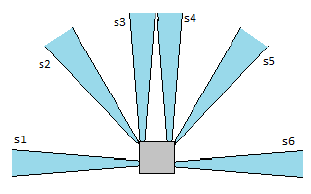

DISEÑO DEL CONTROLADOR FUZZY
Se ha seleccionado el controlador Fuzzy debido a su operatividad en sistemas MIMO (Multiple Input - Multiple Output). En un controlador Fuzzy se usa como entradas conjuntos borrosos, los cuales dependen del estado del robot, que en este caso está dado por la distancia medida por los sensores.

Se ha seleccionado el método de Inferencia Borrosa Mamdani, el cual es usado en casos prácticos y cuando el número de variables lingüísticas es reducido.

#### Definicion de entradas

Para reducir el número de entradas, y por consiguiente de reglas del sistema, no se usan los sensores S1 y S6 como entradas independientes, sino que su diferencia genera una sola entrada. De la misma forma se usa la diferencia de los sensores esquineros S2 y S5 como otra entrada.

Tanto los sensores S3 y S4 se usan como entradas independientes.


*   La entrada 1, con información del sensor S3, tiene dos subconjuntos trapezoidales, Pequeño (P) y Grande (G), y un triangular central, Mediando (M).
*   La entrada 2, con información del sensor S4 tiene la misma configuración y distribución que la entrada 1.
*   La entrada 3, con información de la diferencia entre S2 y S5, se distribuye en tres subconjuntos similares a la entrada 1 y con nombres Negativo (N), Cero (Z) y Positivo (P).
*   La entrada 4, con información de la diferencia entre los sensores S1 y S6 tiene dos subconjuntos trapezoidales ubicados de tal forma que el valor borroso es prácticamente un valor digital, así cuando el subconjunto Negativo (N) está en 1 el subconjunto Positivo (P) está en 0, y viceversa.





In [4]:
v_s3 = ["P", "M", "G"]
v_s4 = ["P", "M", "G"]
v_diff_esquineros = ["N", "Z", "P"]
v_diff_laterales = ["N", "P"]
v_linear_velocity = ["PP", "PM", "M", "GM", "GG"]
v_angular_velocity = ["N", "NM", "ZN", "Z", "ZP", "PM", "P"]

## Funciones de membresía para las entradas y salidas

In [5]:
# Funciones de membresía para S3 y S4
s3_p = fuzz.trapmf(universe_s3, [0, 0, 50, 150])    # Pequeño
s3_m = fuzz.trimf(universe_s3, [50, 150, 250])      # Medio
s3_g = fuzz.trapmf(universe_s3, [150, 250, 400, 400])  # Grande
fuzzy_s3 = [s3_p, s3_m, s3_g]

s4_p = fuzz.trapmf(universe_s4, [0, 0, 50, 150])
s4_m = fuzz.trimf(universe_s4, [50, 150, 250])
s4_g = fuzz.trapmf(universe_s4, [150, 250, 400, 400])
fuzzy_s4 = [s4_p,s4_m,s4_g]

# Funciones de membresía para diff_esquineros (S2 - S5)
diff_esq_n = fuzz.trapmf(universe_diff_esquineros, [-200, -200, -100, 0])  # Negativo
diff_esq_z = fuzz.trimf(universe_diff_esquineros, [-100, 0, 100])          # Cero
diff_esq_p = fuzz.trapmf(universe_diff_esquineros, [0, 100, 200, 200])     # Positivo
fuzzy_diff_esquineros = [diff_esq_n, diff_esq_z, diff_esq_p]

# Funciones de membresía para diff_laterales (S1 - S6)
diff_lat_n = fuzz.trapmf(universe_diff_laterales, [-200, -200, -100, 0])  # Negativo
diff_lat_p = fuzz.trapmf(universe_diff_laterales, [0, 100, 200, 200])     # Positivo
fuzzy_diff_laterales = [diff_lat_n, diff_lat_p]

# Funciones de membresía para vel_lineal
vel_lineal_pp = fuzz.trimf(universe_linear_velocity, [0, 0, 0.25])    # Pequeño Pequeño
vel_lineal_pm = fuzz.trimf(universe_linear_velocity, [0, 0.25, 0.5])  # Pequeño Medio
vel_lineal_m  = fuzz.trimf(universe_linear_velocity, [0.25, 0.5, 0.75])  # Medio
vel_lineal_gm = fuzz.trimf(universe_linear_velocity, [0.5, 0.75, 1])  # Grande Medio
vel_lineal_gg = fuzz.trimf(universe_linear_velocity, [0.75, 1, 1])     # Grande Grande
fuzzy_vel_lineal = [vel_lineal_pp, vel_lineal_pm, vel_lineal_m, vel_lineal_gm, vel_lineal_gg]

# Funciones de membresía para vel_angular
vel_angular_n  = fuzz.trimf(universe_angular_velocity, [-1, -1, -0.2])   # Negativo
vel_angular_nm = fuzz.trimf(universe_angular_velocity, [-0.6, -0.45, 0]) # Negativo Medio
vel_angular_zn = fuzz.trimf(universe_angular_velocity, [-0.45, -0.2, 0])  # Cero Negativo
vel_angular_z  = fuzz.trimf(universe_angular_velocity, [-0.4, 0, 0.4])   # Cero
vel_angular_zp = fuzz.trimf(universe_angular_velocity, [0, 0.2, 0.5])    # Cero Positivo
vel_angular_pm = fuzz.trimf(universe_angular_velocity, [0, 0.45, 0.6])    # Positivo Medio
vel_angular_p  = fuzz.trimf(universe_angular_velocity, [0.2, 1, 1.01])      # Positivo
fuzzy_vel_angular = [vel_angular_n, vel_angular_nm, vel_angular_zn, vel_angular_z, vel_angular_zp, vel_angular_pm, vel_angular_p]

In [6]:
def plot_membfunction(universe, fuzzysets, namesfuzzysets, namevariable=''):
    plt.figure()
    for fset, n in zip(fuzzysets, namesfuzzysets):
        plt.plot(universe, fset, label=n)
    plt.xlabel(namevariable)
    plt.ylabel('Grado de Membresía')
    plt.title(f'Funciones de Membresía para {namevariable}')
    plt.legend()
    plt.show()

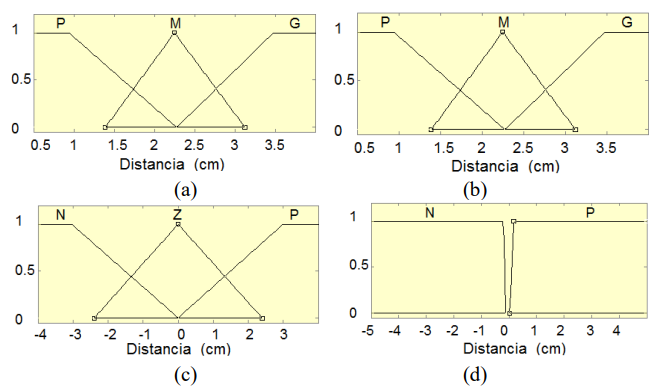

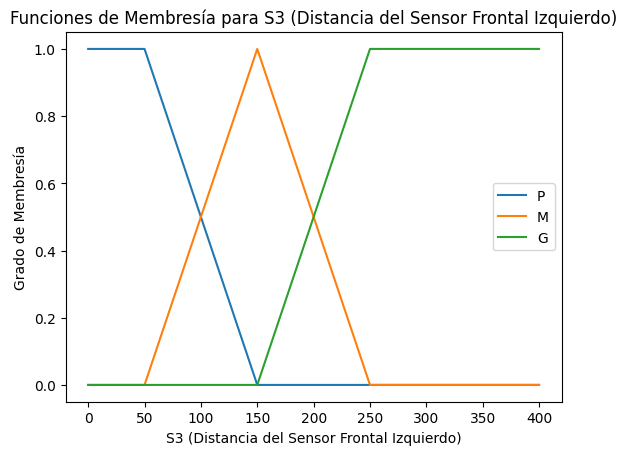

In [7]:
plot_membfunction(
    universe=universe_s3,
    fuzzysets=fuzzy_s3,
    namesfuzzysets=v_s3,
    namevariable='S3 (Distancia del Sensor Frontal Izquierdo)'
)


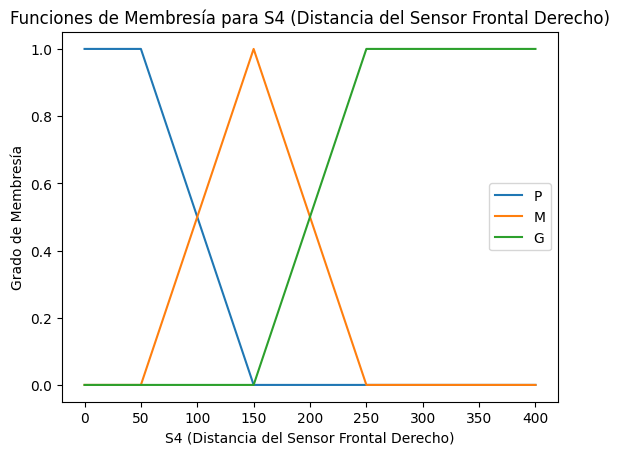

In [8]:
plot_membfunction(
    universe=universe_s4,
    fuzzysets=fuzzy_s4,
    namesfuzzysets=v_s4,
    namevariable='S4 (Distancia del Sensor Frontal Derecho)'
)


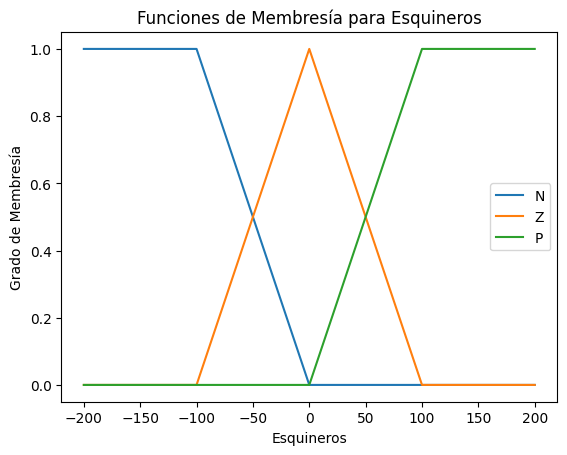

In [9]:
plot_membfunction(
    universe=universe_diff_esquineros,
    fuzzysets=fuzzy_diff_esquineros,
    namesfuzzysets=v_diff_esquineros,
    namevariable='Esquineros')

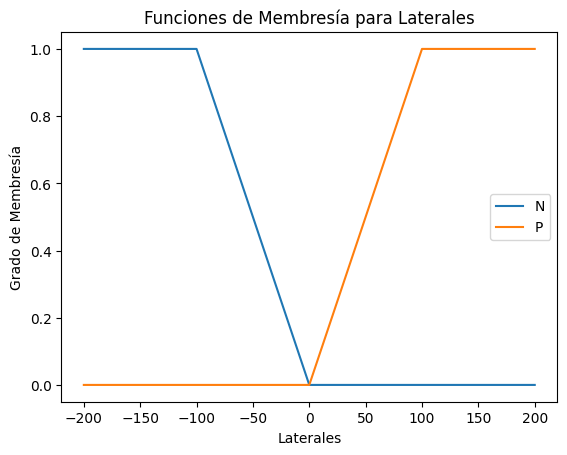

In [10]:
plot_membfunction(
    universe=universe_diff_laterales,
    fuzzysets=fuzzy_diff_laterales,
    namesfuzzysets=v_diff_laterales,
    namevariable='Laterales')

Se han considerado 7 subconjuntos triangulares distribuidos uniformemente a lo largo del rango de la velocidad lineal, lo que permite tener una salida dinámica para todo su rango. Los subconjuntos borrosos son: Pequeño Pequeño (PP), Pequeño Medio (PM), Medio (M), Grande Medio (GM) y Grande Grande (GG).
Para la salida de velocidad angular se consideró los siguientes 7 subconjuntos borrosos: Negativo (N), Negativo Medio (NM), Cero Negativo, (ZN), Cero (Z), Cero Positivo (ZP), Positivo Medio (PM) y Positivo (P), como se observa en la Fig. 5 (b).

Los subconjuntos N y P se ubican en los extremos del rango de la velocidad angular mientras los demás subconjuntos están alrededor de la velocidad nula. Con esta distribución la dinámica de la respuesta es tal, que es más sensible a cambios alrededor de 0 (rad/s).

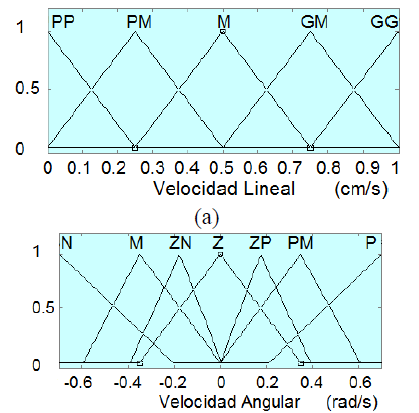

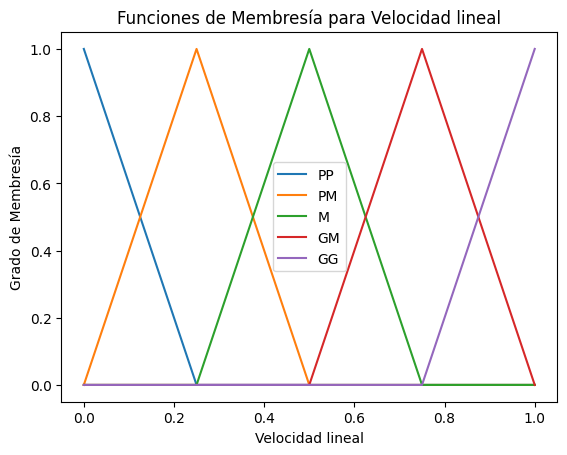

In [11]:
plot_membfunction(
    universe=universe_linear_velocity,
    fuzzysets=fuzzy_vel_lineal,
    namesfuzzysets=v_linear_velocity,
    namevariable='Velocidad lineal'
)

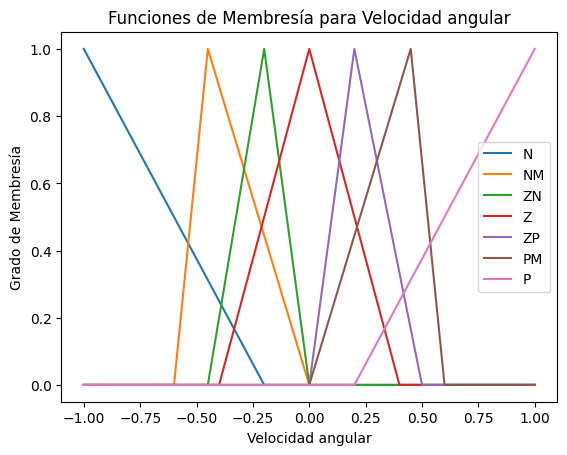

In [12]:
plot_membfunction(
    universe=universe_angular_velocity,
    fuzzysets=fuzzy_vel_angular,
    namesfuzzysets=v_angular_velocity,
    namevariable='Velocidad angular'
)

Suponiendo que se calcula con los siguientes valores:



In [13]:
# Valores de entrada para S3, S4, laterales y esquineros
sensor_s3 = 18
sensor_s4 = 60
sensores_laterales = 18
sensores_esquineros = 60

# Cálculo de los valores de membresía
mf_s3 = [fuzz.interp_membership(universe_s3, mf, sensor_s3) for mf in fuzzy_s3]
mf_s4 = [fuzz.interp_membership(universe_s4, mf, sensor_s4) for mf in fuzzy_s4]
mf_laterales = [fuzz.interp_membership(universe_diff_laterales, mf, sensores_laterales) for mf in fuzzy_diff_laterales]
mf_esquineros = [fuzz.interp_membership(universe_diff_esquineros, mf, sensores_esquineros) for mf in fuzzy_diff_esquineros]


mf_s3, mf_s4, mf_laterales, mf_esquineros

([1.0, 0.0, 0.0], [0.9, 0.1, 0.0], [0.0, 0.18], [0.0, 0.4, 0.6])

# Definición de las 26 reglas

In [14]:
import pandas as pd

# Definimos las columnas de la tabla que representarán las reglas
columns = ['S3', 'S4', 'diff_esquineros', 'diff_laterales', 'vel_lineal', 'vel_angular']

# Creamos una lista con las reglas en formato de tabla
rules_data = [
    ['P', 'P', 'N', 'N', 'PP', 'N'],
    ['P', 'P', 'N', 'P', 'PP', 'P'],
    ['P', 'P', 'Z', 'N', 'PP', 'N'],
    ['P', 'P', 'Z', 'P', 'PP', 'P'],
    ['P', 'P', 'P', 'N', 'PP', 'N'],
    ['P', 'P', 'P', 'P', 'PP', 'P'],
    ['M', 'P', 'N', '-', 'PM', 'N'],
    ['M', 'P', 'Z', '-', 'M', 'PM'],
    ['M', 'P', 'P', '-', 'GM', 'P'],
    ['M', 'M', 'N', '-', 'M', 'N'],
    ['M', 'M', 'Z', '-', 'GM', 'Z'],
    ['M', 'M', 'P', '-', 'M', 'P'],
    ['M', 'G', 'N', '-', 'GG', 'NM'],
    ['M', 'G', 'Z', '-', 'GG', 'Z'],
    ['M', 'G', 'P', '-', 'M', 'NM'],
    ['P', 'M', 'N', '-', 'GM', 'N'],
    ['P', 'M', 'Z', '-', 'M', 'NM'],
    ['P', 'M', 'P', '-', 'PM', 'P'],
    ['G', 'G', 'N', '-', 'GG', 'N'],
    ['G', 'G', 'Z', '-', 'GG', 'Z'],
    ['G', 'G', 'P', '-', 'GG', 'P'],
    ['G', 'M', 'N', '-', 'M', 'PM'],
    ['G', 'M', 'Z', '-', 'GG', 'Z'],
    ['G', 'M', 'P', '-', 'GG', 'PM'],
    ['G', 'P', '-', '-', 'M', 'ZP'],
    ['P', 'G', '-', '-', 'M', 'ZN'],
]

# Creamos el DataFrame a partir de las reglas
df_rules = pd.DataFrame(rules_data, columns=columns)

df_rules

,S3,S4,diff_esquineros,diff_laterales,vel_lineal,vel_angular
0,P,P,N,N,PP,N
1,P,P,N,P,PP,P
2,P,P,Z,N,PP,N
3,P,P,Z,P,PP,P
4,P,P,P,N,PP,N
5,P,P,P,P,PP,P
6,M,P,N,-,PM,N
7,M,P,Z,-,M,PM
8,M,P,P,-,GM,P
9,M,M,N,-,M,N


El set de reglas se compone de 26 combinaciones en donde I1
es la variable lingüística Distancia 1 de la entrada 1, I2 es la
variable Distancia 2 de la entrada 2, I3 es la diferencia de
distancias correspondiente a la entrada 3, I4 es la diferencia
de los sensores laterales, entrada 4. Las

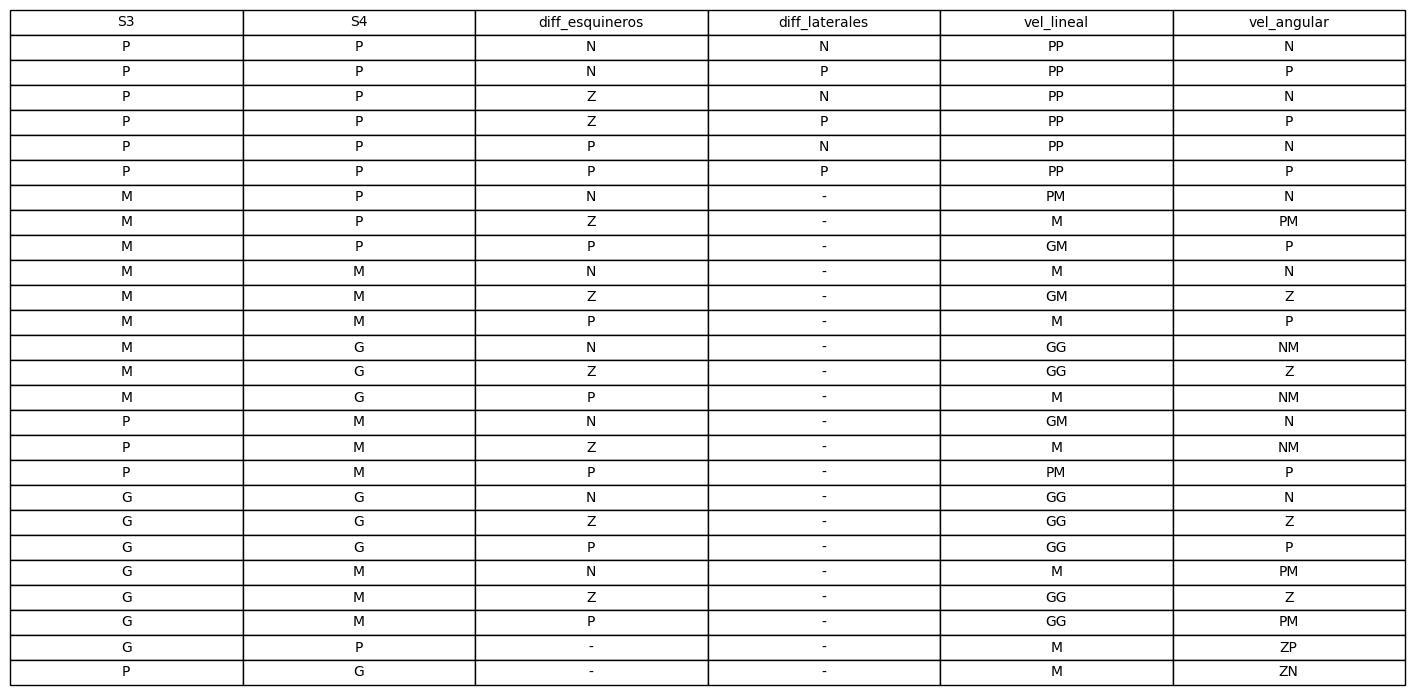

In [15]:
import matplotlib.pyplot as plt

# Visualizar la tabla con estilo
fig, ax = plt.subplots(figsize=(12, 8))  # Ajustar tamaño si es necesario
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_rules.values, colLabels=df_rules.columns, loc='center', cellLoc='center')

# Aplicar estilos opcionales
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.5, 1.5)  # Ajustar el tamaño de la tabla

plt.show()

In [16]:
# Definimos las reglas restantes siguiendo el mismo formato que el ejemplo dado.

# Regla 1
rule1_ant1 = np.fmin(mf_s3[v_s3.index('P')], mf_s4[v_s4.index('P')])
rule1_ant2 = np.fmin(mf_esquineros[v_diff_esquineros.index('N')], mf_laterales[v_diff_laterales.index('N')])
rule1_ant = np.min([rule1_ant1, rule1_ant2])
act_rule1_lineal = np.fmin(rule1_ant, fuzzy_vel_lineal[v_linear_velocity.index('PP')])
act_rule1_angular = np.fmin(rule1_ant, fuzzy_vel_angular[v_angular_velocity.index('N')])

# Regla 2
rule2_ant1 = np.fmin(mf_s3[v_s3.index('P')], mf_s4[v_s4.index('P')])
rule2_ant2 = np.fmin(mf_esquineros[v_diff_esquineros.index('N')], mf_laterales[v_diff_laterales.index('P')])
rule2_ant = np.min([rule2_ant1, rule2_ant2])
act_rule2_lineal = np.fmin(rule2_ant, fuzzy_vel_lineal[v_linear_velocity.index('PP')])
act_rule2_angular = np.fmin(rule2_ant, fuzzy_vel_angular[v_angular_velocity.index('P')])

# Regla 3
rule3_ant1 = np.fmin(mf_s3[v_s3.index('P')], mf_s4[v_s4.index('P')])
rule3_ant2 = np.fmin(mf_esquineros[v_diff_esquineros.index('Z')], mf_laterales[v_diff_laterales.index('N')])
rule3_ant = np.min([rule3_ant1, rule3_ant2])
act_rule3_lineal = np.fmin(rule3_ant, fuzzy_vel_lineal[v_linear_velocity.index('PP')])
act_rule3_angular = np.fmin(rule3_ant, fuzzy_vel_angular[v_angular_velocity.index('N')])

# Regla 4
rule4_ant1 = np.fmin(mf_s3[v_s3.index('P')], mf_s4[v_s4.index('P')])
rule4_ant2 = np.fmin(mf_esquineros[v_diff_esquineros.index('Z')], mf_laterales[v_diff_laterales.index('P')])
rule4_ant = np.min([rule4_ant1, rule4_ant2])
act_rule4_lineal = np.fmin(rule4_ant, fuzzy_vel_lineal[v_linear_velocity.index('PP')])
act_rule4_angular = np.fmin(rule4_ant, fuzzy_vel_angular[v_angular_velocity.index('P')])

# Regla 5
rule5_ant1 = np.fmin(mf_s3[v_s3.index('P')], mf_s4[v_s4.index('P')])
rule5_ant2 = np.fmin(mf_esquineros[v_diff_esquineros.index('P')], mf_laterales[v_diff_laterales.index('N')])
rule5_ant = np.min([rule5_ant1, rule5_ant2])
act_rule5_lineal = np.fmin(rule5_ant, fuzzy_vel_lineal[v_linear_velocity.index('PP')])
act_rule5_angular = np.fmin(rule5_ant, fuzzy_vel_angular[v_angular_velocity.index('N')])

# Regla 6
rule6_ant1 = np.fmin(mf_s3[v_s3.index('P')], mf_s4[v_s4.index('P')])
rule6_ant2 = np.fmin(mf_esquineros[v_diff_esquineros.index('P')], mf_laterales[v_diff_laterales.index('P')])
rule6_ant = np.min([rule6_ant1, rule6_ant2])
act_rule6_lineal = np.fmin(rule6_ant, fuzzy_vel_lineal[v_linear_velocity.index('PP')])
act_rule6_angular = np.fmin(rule6_ant, fuzzy_vel_angular[v_angular_velocity.index('P')])

# Regla 7
rule7_ant1 = np.fmin(mf_s3[v_s3.index('M')], mf_s4[v_s4.index('P')])
rule7_ant2 = mf_esquineros[v_diff_esquineros.index('N')]
rule7_ant = np.min([rule7_ant1, rule7_ant2])
act_rule7_lineal = np.fmin(rule7_ant, fuzzy_vel_lineal[v_linear_velocity.index('PM')])
act_rule7_angular = np.fmin(rule7_ant, fuzzy_vel_angular[v_angular_velocity.index('N')])

# Regla 8
rule8_ant1 = np.fmin(mf_s3[v_s3.index('M')], mf_s4[v_s4.index('P')])
rule8_ant2 = mf_esquineros[v_diff_esquineros.index('Z')]
rule8_ant = np.min([rule8_ant1, rule8_ant2])
act_rule8_lineal = np.fmin(rule8_ant, fuzzy_vel_lineal[v_linear_velocity.index('M')])
act_rule8_angular = np.fmin(rule8_ant, fuzzy_vel_angular[v_angular_velocity.index('PM')])

# Regla 9
rule9_ant1 = np.fmin(mf_s3[v_s3.index('M')], mf_s4[v_s4.index('P')])
rule9_ant2 = mf_esquineros[v_diff_esquineros.index('P')]
rule9_ant = np.min([rule9_ant1, rule9_ant2])
act_rule9_lineal = np.fmin(rule9_ant, fuzzy_vel_lineal[v_linear_velocity.index('GM')])
act_rule9_angular = np.fmin(rule9_ant, fuzzy_vel_angular[v_angular_velocity.index('P')])

# Regla 10
rule10_ant1 = np.fmin(mf_s3[v_s3.index('M')], mf_s4[v_s4.index('M')])
rule10_ant2 = mf_esquineros[v_diff_esquineros.index('N')]
rule10_ant = np.min([rule10_ant1, rule10_ant2])
act_rule10_lineal = np.fmin(rule10_ant, fuzzy_vel_lineal[v_linear_velocity.index('M')])
act_rule10_angular = np.fmin(rule10_ant, fuzzy_vel_angular[v_angular_velocity.index('N')])

# Regla 11
rule11_ant1 = np.fmin(mf_s3[v_s3.index('M')], mf_s4[v_s4.index('M')])
rule11_ant2 = mf_esquineros[v_diff_esquineros.index('Z')]
rule11_ant = np.min([rule11_ant1, rule11_ant2])
act_rule11_lineal = np.fmin(rule11_ant, fuzzy_vel_lineal[v_linear_velocity.index('GM')])
act_rule11_angular = np.fmin(rule11_ant, fuzzy_vel_angular[v_angular_velocity.index('Z')])

# Regla 12
rule12_ant1 = np.fmin(mf_s3[v_s3.index('M')], mf_s4[v_s4.index('M')])
rule12_ant2 = mf_esquineros[v_diff_esquineros.index('P')]
rule12_ant = np.min([rule12_ant1, rule12_ant2])
act_rule12_lineal = np.fmin(rule12_ant, fuzzy_vel_lineal[v_linear_velocity.index('M')])
act_rule12_angular = np.fmin(rule12_ant, fuzzy_vel_angular[v_angular_velocity.index('P')])

# Regla 13
rule13_ant1 = np.fmin(mf_s3[v_s3.index('M')], mf_s4[v_s4.index('G')])
rule13_ant2 = mf_esquineros[v_diff_esquineros.index('N')]
rule13_ant = np.min([rule13_ant1, rule13_ant2])
act_rule13_lineal = np.fmin(rule13_ant, fuzzy_vel_lineal[v_linear_velocity.index('GG')])
act_rule13_angular = np.fmin(rule13_ant, fuzzy_vel_angular[v_angular_velocity.index('NM')])

# Regla 14
rule14_ant1 = np.fmin(mf_s3[v_s3.index('M')], mf_s4[v_s4.index('G')])
rule14_ant2 = mf_esquineros[v_diff_esquineros.index('Z')]
rule14_ant = np.min([rule14_ant1, rule14_ant2])
act_rule14_lineal = np.fmin(rule14_ant, fuzzy_vel_lineal[v_linear_velocity.index('GG')])
act_rule14_angular = np.fmin(rule14_ant, fuzzy_vel_angular[v_angular_velocity.index('Z')])

# Regla 15
rule15_ant1 = np.fmin(mf_s3[v_s3.index('M')], mf_s4[v_s4.index('G')])
rule15_ant2 = mf_esquineros[v_diff_esquineros.index('P')]
rule15_ant = np.min([rule15_ant1, rule15_ant2])
act_rule15_lineal = np.fmin(rule15_ant, fuzzy_vel_lineal[v_linear_velocity.index('M')])
act_rule15_angular = np.fmin(rule15_ant, fuzzy_vel_angular[v_angular_velocity.index('NM')])

# Regla 16
rule16_ant1 = np.fmin(mf_s3[v_s3.index('P')], mf_s4[v_s4.index('M')])
rule16_ant2 = mf_esquineros[v_diff_esquineros.index('N')]
rule16_ant = np.min([rule16_ant1, rule16_ant2])
act_rule16_lineal = np.fmin(rule16_ant, fuzzy_vel_lineal[v_linear_velocity.index('GM')])
act_rule16_angular = np.fmin(rule16_ant, fuzzy_vel_angular[v_angular_velocity.index('N')])

# Regla 17
rule17_ant1 = np.fmin(mf_s3[v_s3.index('P')], mf_s4[v_s4.index('M')])
rule17_ant2 = mf_esquineros[v_diff_esquineros.index('Z')]
rule17_ant = np.min([rule17_ant1, rule17_ant2])
act_rule17_lineal = np.fmin(rule17_ant, fuzzy_vel_lineal[v_linear_velocity.index('M')])
act_rule17_angular = np.fmin(rule17_ant, fuzzy_vel_angular[v_angular_velocity.index('NM')])

# Regla 18
rule18_ant1 = np.fmin(mf_s3[v_s3.index('P')], mf_s4[v_s4.index('M')])
rule18_ant2 = mf_esquineros[v_diff_esquineros.index('P')]
rule18_ant = np.min([rule18_ant1, rule18_ant2])
act_rule18_lineal = np.fmin(rule18_ant, fuzzy_vel_lineal[v_linear_velocity.index('PM')])
act_rule18_angular = np.fmin(rule18_ant, fuzzy_vel_angular[v_angular_velocity.index('P')])

# Regla 19
rule19_ant1 = np.fmin(mf_s3[v_s3.index('G')], mf_s4[v_s4.index('G')])
rule19_ant2 = mf_esquineros[v_diff_esquineros.index('N')]
rule19_ant = np.min([rule19_ant1, rule19_ant2])
act_rule19_lineal = np.fmin(rule19_ant, fuzzy_vel_lineal[v_linear_velocity.index('GG')])
act_rule19_angular = np.fmin(rule19_ant, fuzzy_vel_angular[v_angular_velocity.index('N')])

# Regla 20
rule20_ant1 = np.fmin(mf_s3[v_s3.index('G')], mf_s4[v_s4.index('G')])
rule20_ant2 = mf_esquineros[v_diff_esquineros.index('Z')]
rule20_ant = np.min([rule20_ant1, rule20_ant2])
act_rule20_lineal = np.fmin(rule20_ant, fuzzy_vel_lineal[v_linear_velocity.index('GG')])
act_rule20_angular = np.fmin(rule20_ant, fuzzy_vel_angular[v_angular_velocity.index('Z')])

# Regla 21
rule21_ant1 = np.fmin(mf_s3[v_s3.index('G')], mf_s4[v_s4.index('G')])
rule21_ant2 = mf_esquineros[v_diff_esquineros.index('P')]
rule21_ant = np.min([rule21_ant1, rule21_ant2])
act_rule21_lineal = np.fmin(rule21_ant, fuzzy_vel_lineal[v_linear_velocity.index('GG')])
act_rule21_angular = np.fmin(rule21_ant, fuzzy_vel_angular[v_angular_velocity.index('P')])

# Regla 22
rule22_ant1 = np.fmin(mf_s3[v_s3.index('G')], mf_s4[v_s4.index('M')])
rule22_ant2 = mf_esquineros[v_diff_esquineros.index('N')]
rule22_ant = np.min([rule22_ant1, rule22_ant2])
act_rule22_lineal = np.fmin(rule22_ant, fuzzy_vel_lineal[v_linear_velocity.index('M')])
act_rule22_angular = np.fmin(rule22_ant, fuzzy_vel_angular[v_angular_velocity.index('PM')])

# Regla 23
rule23_ant1 = np.fmin(mf_s3[v_s3.index('G')], mf_s4[v_s4.index('M')])
rule23_ant2 = mf_esquineros[v_diff_esquineros.index('Z')]
rule23_ant = np.min([rule23_ant1, rule23_ant2])
act_rule23_lineal = np.fmin(rule23_ant, fuzzy_vel_lineal[v_linear_velocity.index('GG')])
act_rule23_angular = np.fmin(rule23_ant, fuzzy_vel_angular[v_angular_velocity.index('Z')])

# Regla 24
rule24_ant1 = np.fmin(mf_s3[v_s3.index('G')], mf_s4[v_s4.index('M')])
rule24_ant2 = mf_esquineros[v_diff_esquineros.index('P')]
rule24_ant = np.min([rule24_ant1, rule24_ant2])
act_rule24_lineal = np.fmin(rule24_ant, fuzzy_vel_lineal[v_linear_velocity.index('GG')])
act_rule24_angular = np.fmin(rule24_ant, fuzzy_vel_angular[v_angular_velocity.index('PM')])

# Regla 25
rule25_ant1 = np.fmin(mf_s3[v_s3.index('G')], mf_s4[v_s4.index('P')])
rule25_ant = rule25_ant1
act_rule25_lineal = np.fmin(rule25_ant, fuzzy_vel_lineal[v_linear_velocity.index('M')])
act_rule25_angular = np.fmin(rule25_ant, fuzzy_vel_angular[v_angular_velocity.index('ZP')])

# Regla 26
rule26_ant1 = np.fmin(mf_s3[v_s3.index('P')], mf_s4[v_s4.index('G')])
rule26_ant = rule26_ant1
act_rule26_lineal = np.fmin(rule26_ant, fuzzy_vel_lineal[v_linear_velocity.index('M')])
act_rule26_angular = np.fmin(rule26_ant, fuzzy_vel_angular[v_angular_velocity.index('ZN')])


In [17]:
import matplotlib.pyplot as plt

# Unimos las reglas para la velocidad lineal
yr1_r2_lineal, unionr1_r2_lineal = fuzz.fuzzy_or(universe_linear_velocity, act_rule1_lineal, universe_linear_velocity, act_rule2_lineal)
yr3_union_lineal, unionr1_r2_r3_lineal = fuzz.fuzzy_or(universe_linear_velocity, unionr1_r2_lineal, universe_linear_velocity, act_rule3_lineal)
# Continua uniendo todas las reglas
_, unionr4_lineal = fuzz.fuzzy_or(universe_linear_velocity, unionr1_r2_r3_lineal, universe_linear_velocity, act_rule4_lineal)
_, unionr5_lineal = fuzz.fuzzy_or(universe_linear_velocity, unionr4_lineal, universe_linear_velocity, act_rule5_lineal)
_, unionr6_lineal = fuzz.fuzzy_or(universe_linear_velocity, unionr5_lineal, universe_linear_velocity, act_rule6_lineal)
_, unionr7_lineal = fuzz.fuzzy_or(universe_linear_velocity, unionr6_lineal, universe_linear_velocity, act_rule7_lineal)
_, unionr8_lineal = fuzz.fuzzy_or(universe_linear_velocity, unionr7_lineal, universe_linear_velocity, act_rule8_lineal)
_, unionr9_lineal = fuzz.fuzzy_or(universe_linear_velocity, unionr8_lineal, universe_linear_velocity, act_rule9_lineal)
_, unionr10_lineal = fuzz.fuzzy_or(universe_linear_velocity, unionr9_lineal, universe_linear_velocity, act_rule10_lineal)
_, unionr11_lineal = fuzz.fuzzy_or(universe_linear_velocity, unionr10_lineal, universe_linear_velocity, act_rule11_lineal)
_, unionr12_lineal = fuzz.fuzzy_or(universe_linear_velocity, unionr11_lineal, universe_linear_velocity, act_rule12_lineal)
_, unionr13_lineal = fuzz.fuzzy_or(universe_linear_velocity, unionr12_lineal, universe_linear_velocity, act_rule13_lineal)
_, unionr14_lineal = fuzz.fuzzy_or(universe_linear_velocity, unionr13_lineal, universe_linear_velocity, act_rule14_lineal)
_, unionr15_lineal = fuzz.fuzzy_or(universe_linear_velocity, unionr14_lineal, universe_linear_velocity, act_rule15_lineal)
_, unionr16_lineal = fuzz.fuzzy_or(universe_linear_velocity, unionr15_lineal, universe_linear_velocity, act_rule16_lineal)
_, unionr17_lineal = fuzz.fuzzy_or(universe_linear_velocity, unionr16_lineal, universe_linear_velocity, act_rule17_lineal)
_, unionr18_lineal = fuzz.fuzzy_or(universe_linear_velocity, unionr17_lineal, universe_linear_velocity, act_rule18_lineal)
_, unionr19_lineal = fuzz.fuzzy_or(universe_linear_velocity, unionr18_lineal, universe_linear_velocity, act_rule19_lineal)
_, unionr20_lineal = fuzz.fuzzy_or(universe_linear_velocity, unionr19_lineal, universe_linear_velocity, act_rule20_lineal)
_, unionr21_lineal = fuzz.fuzzy_or(universe_linear_velocity, unionr20_lineal, universe_linear_velocity, act_rule21_lineal)
_, unionr22_lineal = fuzz.fuzzy_or(universe_linear_velocity, unionr21_lineal, universe_linear_velocity, act_rule22_lineal)
_, unionr23_lineal = fuzz.fuzzy_or(universe_linear_velocity, unionr22_lineal, universe_linear_velocity, act_rule23_lineal)
_, unionr24_lineal = fuzz.fuzzy_or(universe_linear_velocity, unionr23_lineal, universe_linear_velocity, act_rule24_lineal)
_, unionr25_lineal = fuzz.fuzzy_or(universe_linear_velocity, unionr24_lineal, universe_linear_velocity, act_rule25_lineal)
_, union_final_lineal = fuzz.fuzzy_or(universe_linear_velocity, unionr25_lineal, universe_linear_velocity, act_rule26_lineal)

# Unimos las reglas para la velocidad angular
yr1_r2_angular, unionr1_r2_angular = fuzz.fuzzy_or(universe_angular_velocity, act_rule1_angular, universe_angular_velocity, act_rule2_angular)
yr3_union_angular, unionr1_r2_r3_angular = fuzz.fuzzy_or(universe_angular_velocity, unionr1_r2_angular, universe_angular_velocity, act_rule3_angular)
# Continua uniendo todas las reglas
_, unionr4_angular = fuzz.fuzzy_or(universe_angular_velocity, unionr1_r2_r3_angular, universe_angular_velocity, act_rule4_angular)
_, unionr5_angular = fuzz.fuzzy_or(universe_angular_velocity, unionr4_angular, universe_angular_velocity, act_rule5_angular)
_, unionr6_angular = fuzz.fuzzy_or(universe_angular_velocity, unionr5_angular, universe_angular_velocity, act_rule6_angular)
_, unionr7_angular = fuzz.fuzzy_or(universe_angular_velocity, unionr6_angular, universe_angular_velocity, act_rule7_angular)
_, unionr8_angular = fuzz.fuzzy_or(universe_angular_velocity, unionr7_angular, universe_angular_velocity, act_rule8_angular)
_, unionr9_angular = fuzz.fuzzy_or(universe_angular_velocity, unionr8_angular, universe_angular_velocity, act_rule9_angular)
_, unionr10_angular = fuzz.fuzzy_or(universe_angular_velocity, unionr9_angular, universe_angular_velocity, act_rule10_angular)
_, unionr11_angular = fuzz.fuzzy_or(universe_angular_velocity, unionr10_angular, universe_angular_velocity, act_rule11_angular)
_, unionr12_angular = fuzz.fuzzy_or(universe_angular_velocity, unionr11_angular, universe_angular_velocity, act_rule12_angular)
_, unionr13_angular = fuzz.fuzzy_or(universe_angular_velocity, unionr12_angular, universe_angular_velocity, act_rule13_angular)
_, unionr14_angular = fuzz.fuzzy_or(universe_angular_velocity, unionr13_angular, universe_angular_velocity, act_rule14_angular)
_, unionr15_angular = fuzz.fuzzy_or(universe_angular_velocity, unionr14_angular, universe_angular_velocity, act_rule15_angular)
_, unionr16_angular = fuzz.fuzzy_or(universe_angular_velocity, unionr15_angular, universe_angular_velocity, act_rule16_angular)
_, unionr17_angular = fuzz.fuzzy_or(universe_angular_velocity, unionr16_angular, universe_angular_velocity, act_rule17_angular)
_, unionr18_angular = fuzz.fuzzy_or(universe_angular_velocity, unionr17_angular, universe_angular_velocity, act_rule18_angular)
_, unionr19_angular = fuzz.fuzzy_or(universe_angular_velocity, unionr18_angular, universe_angular_velocity, act_rule19_angular)
_, unionr20_angular = fuzz.fuzzy_or(universe_angular_velocity, unionr19_angular, universe_angular_velocity, act_rule20_angular)
_, unionr21_angular = fuzz.fuzzy_or(universe_angular_velocity, unionr20_angular, universe_angular_velocity, act_rule21_angular)
_, unionr22_angular = fuzz.fuzzy_or(universe_angular_velocity, unionr21_angular, universe_angular_velocity, act_rule22_angular)
_, unionr23_angular = fuzz.fuzzy_or(universe_angular_velocity, unionr22_angular, universe_angular_velocity, act_rule23_angular)
_, unionr24_angular = fuzz.fuzzy_or(universe_angular_velocity, unionr23_angular, universe_angular_velocity, act_rule24_angular)
_, unionr25_angular = fuzz.fuzzy_or(universe_angular_velocity, unionr24_angular, universe_angular_velocity, act_rule25_angular)
_, union_final_angular = fuzz.fuzzy_or(universe_angular_velocity, unionr25_angular, universe_angular_velocity, act_rule26_angular)

# Desfuzzificación (esto usa centroid pero puedes usar cualquier otro método)
centroid_lineal = fuzz.defuzz(universe_linear_velocity, union_final_lineal, 'centroid')
centroid_angular = fuzz.defuzz(universe_angular_velocity, union_final_angular, 'centroid')
y_lineal = fuzz.interp_membership(universe_linear_velocity, union_final_lineal, centroid_lineal)
y_angular = fuzz.interp_membership(universe_angular_velocity, union_final_angular, centroid_angular)

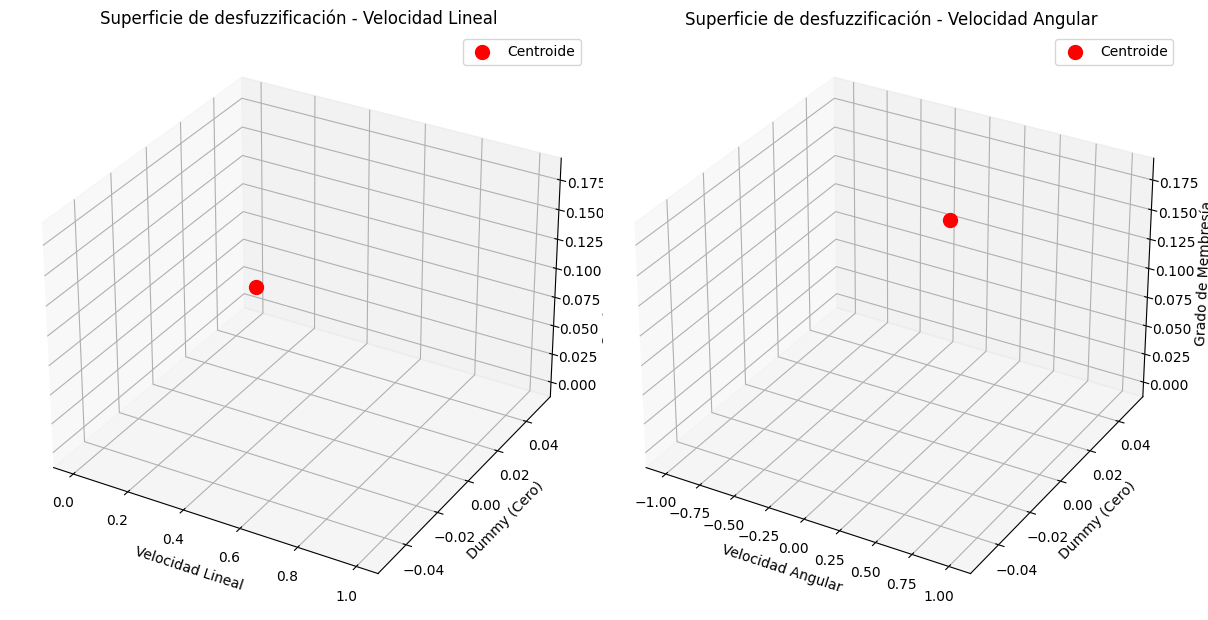

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import skfuzzy as fuzz

# Generar un meshgrid para la velocidad lineal y angular
X, Y = np.meshgrid(universe_linear_velocity, universe_angular_velocity)

# Función para graficar la desfuzzificación en 3D
def graficar_desfuzzificacion_3d(universe_linear_velocity, universe_angular_velocity, union_final_lineal, union_final_angular):
    fig = plt.figure(figsize=(12, 8))

    # Gráfico de la velocidad lineal
    ax1 = fig.add_subplot(121, projection='3d')
    X, Y = np.meshgrid(universe_linear_velocity, np.zeros_like(universe_linear_velocity))
    Z = np.tile(union_final_lineal, (len(universe_linear_velocity), 1))

    ax1.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
    ax1.set_title("Superficie de desfuzzificación - Velocidad Lineal")
    ax1.set_xlabel("Velocidad Lineal")
    ax1.set_ylabel("Dummy (Cero)")
    ax1.set_zlabel("Grado de Membresía")

    # Marcar el centroide
    ax1.scatter(centroid_lineal, 0, y_lineal, color='r', s=100, label="Centroide")
    ax1.legend()

    # Gráfico de la velocidad angular
    ax2 = fig.add_subplot(122, projection='3d')
    X, Y = np.meshgrid(universe_angular_velocity, np.zeros_like(universe_angular_velocity))
    Z = np.tile(union_final_angular, (len(universe_angular_velocity), 1))

    ax2.plot_surface(X, Y, Z, cmap='plasma', edgecolor='none')
    ax2.set_title("Superficie de desfuzzificación - Velocidad Angular")
    ax2.set_xlabel("Velocidad Angular")
    ax2.set_ylabel("Dummy (Cero)")
    ax2.set_zlabel("Grado de Membresía")

    # Marcar el centroide
    ax2.scatter(centroid_angular, 0, y_angular, color='r', s=100, label="Centroide")
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Graficar las superficies 3D de desfuzzificación para velocidad lineal y angular
graficar_desfuzzificacion_3d(universe_linear_velocity, universe_angular_velocity, union_final_lineal, union_final_angular)


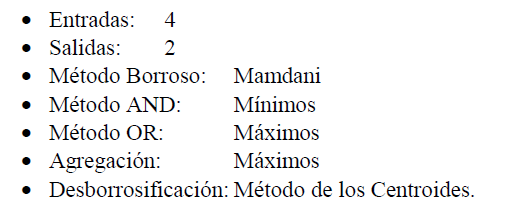

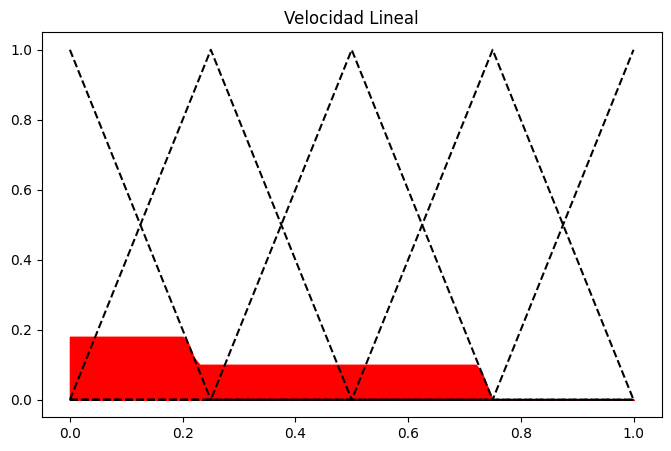

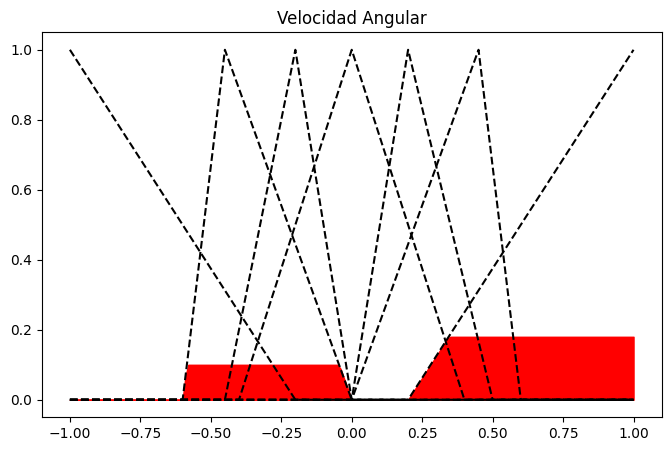

In [18]:
plt.figure(figsize=(8, 5))
for vel_lineal in fuzzy_vel_lineal:
  plt.plot(universe_linear_velocity, vel_lineal, 'k',linestyle='dashed')

plt.fill_between(universe_linear_velocity,0,union_final_lineal, color='red')
plt.title('Velocidad Lineal')
plt.show()

plt.figure(figsize=(8, 5))
for vel_angular in fuzzy_vel_angular:
  plt.plot(universe_angular_velocity, vel_angular, 'k',linestyle='dashed')

plt.fill_between(universe_angular_velocity,0,union_final_angular, color='red')
plt.title('Velocidad Angular')
plt.show()

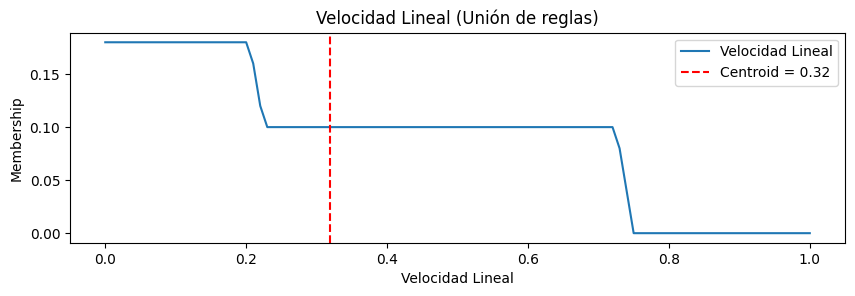

In [19]:
# Plot del resultado final de las reglas unidas para las salidas
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(universe_linear_velocity, union_final_lineal, label='Velocidad Lineal')
plt.title('Velocidad Lineal (Unión de reglas)')
plt.axvline(centroid_lineal, color='r', linestyle='--', label=f'Centroid = {centroid_lineal:.2f}')
plt.ylabel('Membership')
plt.xlabel('Velocidad Lineal')
plt.legend()

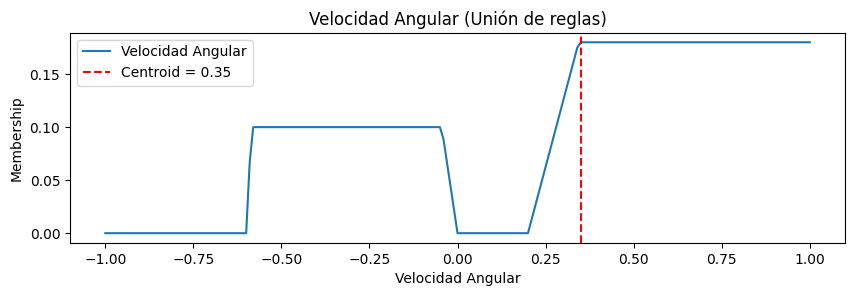

In [20]:
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 2)
plt.plot(universe_angular_velocity, union_final_angular, label='Velocidad Angular')
plt.title('Velocidad Angular (Unión de reglas)')
plt.axvline(centroid_angular, color='r', linestyle='--', label=f'Centroid = {centroid_angular:.2f}')
plt.ylabel('Membership')
plt.xlabel('Velocidad Angular')
plt.legend()

In [21]:
print("La salida será: ")
print("Velocidad lineal: ", centroid_lineal)
print("Velocidad angular: ", centroid_angular)
print("Y Lineal: ", y_lineal)
print("Y Angular: ", y_angular)

La salida será: 
Velocidad lineal:  0.31917491749174925
Velocidad angular:  0.34968543511360267
Y Lineal:  0.1
Y Angular:  0.17984271755680079


Simulación con Velocidad Lineal: 0.1, Velocidad Angular: -0.5


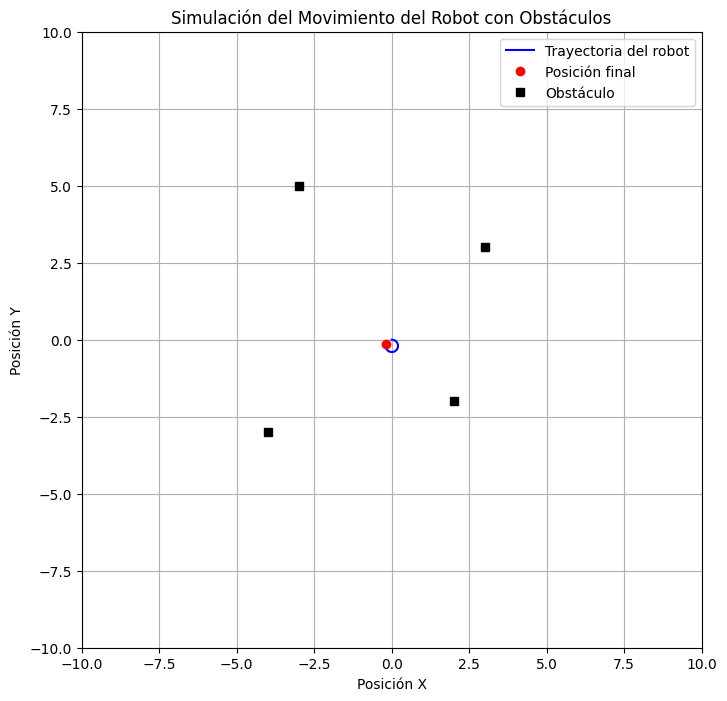

Simulación con Velocidad Lineal: 0.1, Velocidad Angular: -0.25


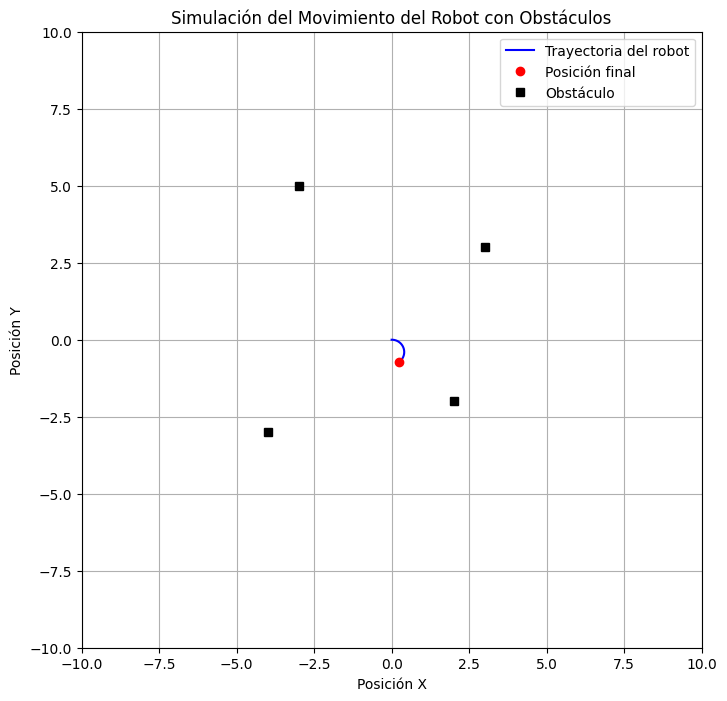

Simulación con Velocidad Lineal: 0.1, Velocidad Angular: 0.0


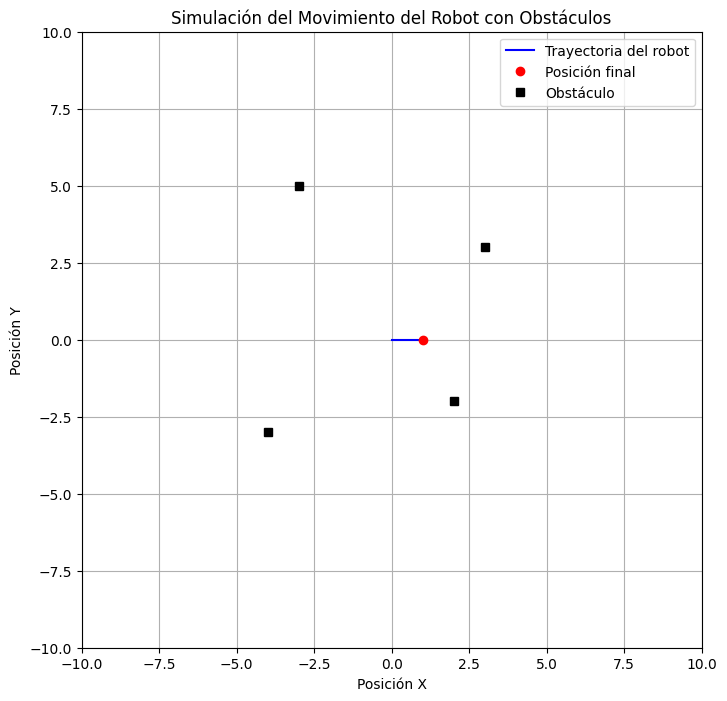

Simulación con Velocidad Lineal: 0.1, Velocidad Angular: 0.25


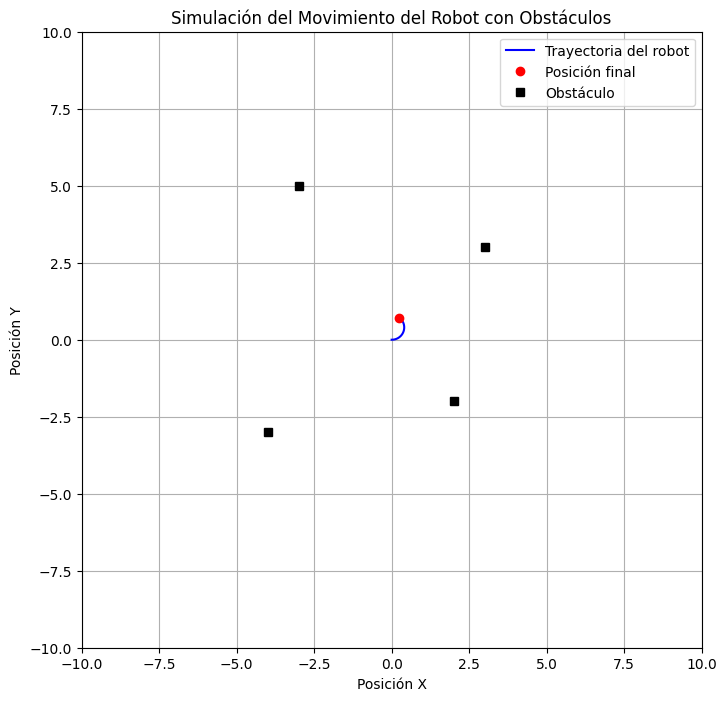

Simulación con Velocidad Lineal: 0.1, Velocidad Angular: 0.5


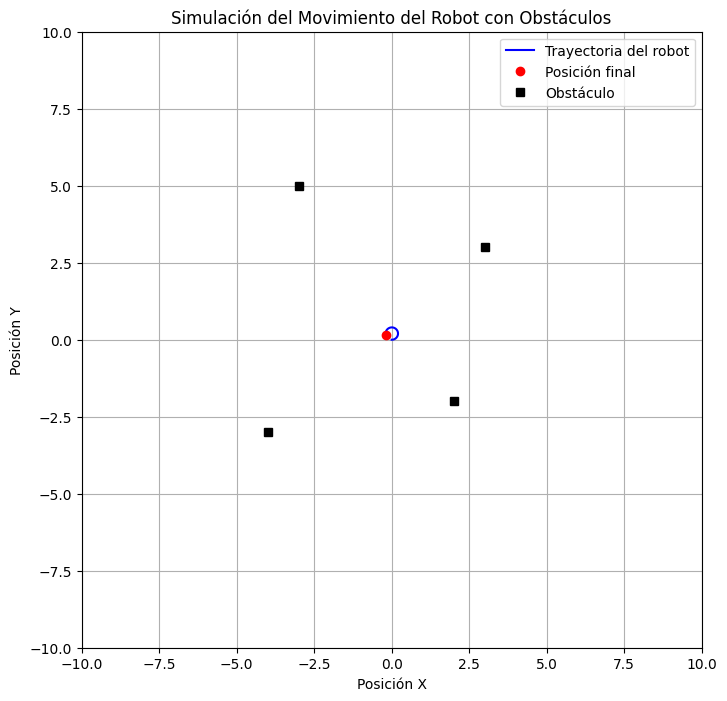

Simulación con Velocidad Lineal: 0.275, Velocidad Angular: -0.5


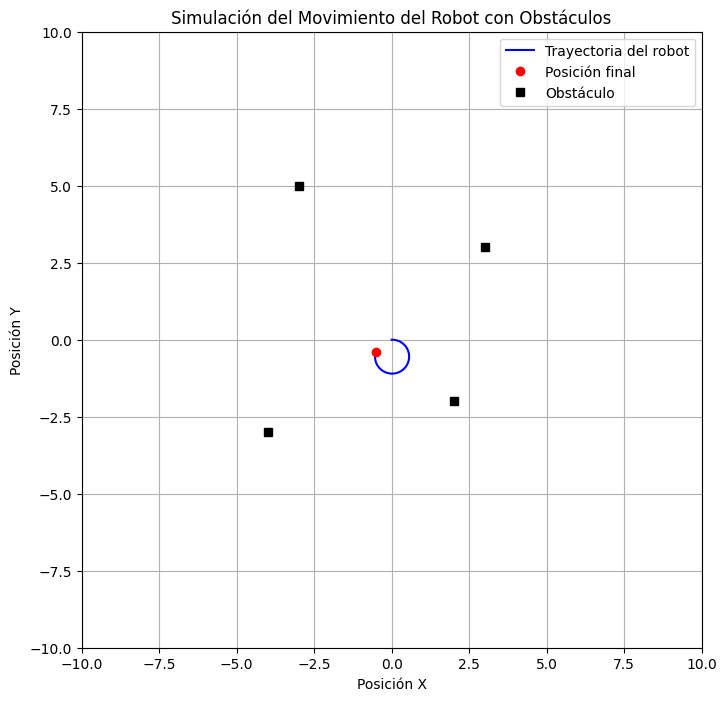

Simulación con Velocidad Lineal: 0.275, Velocidad Angular: -0.25


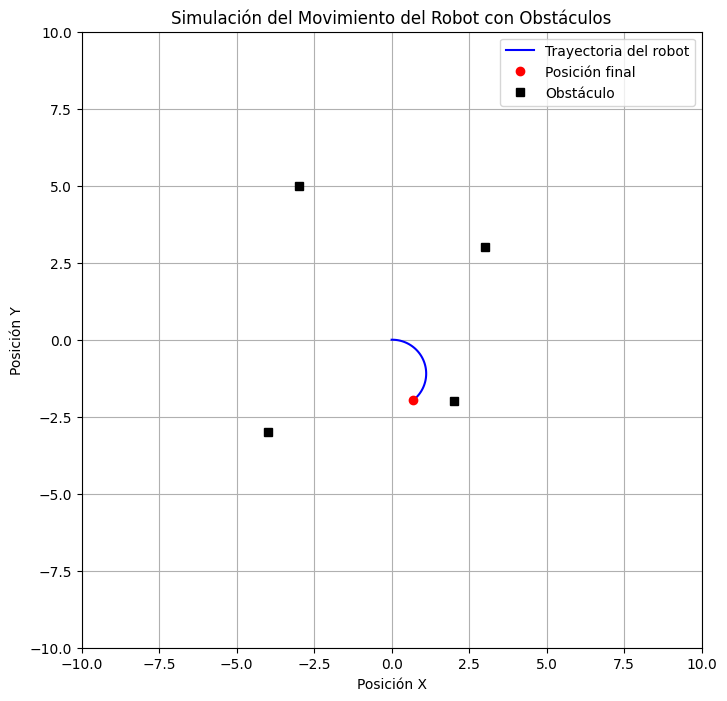

Simulación con Velocidad Lineal: 0.275, Velocidad Angular: 0.0


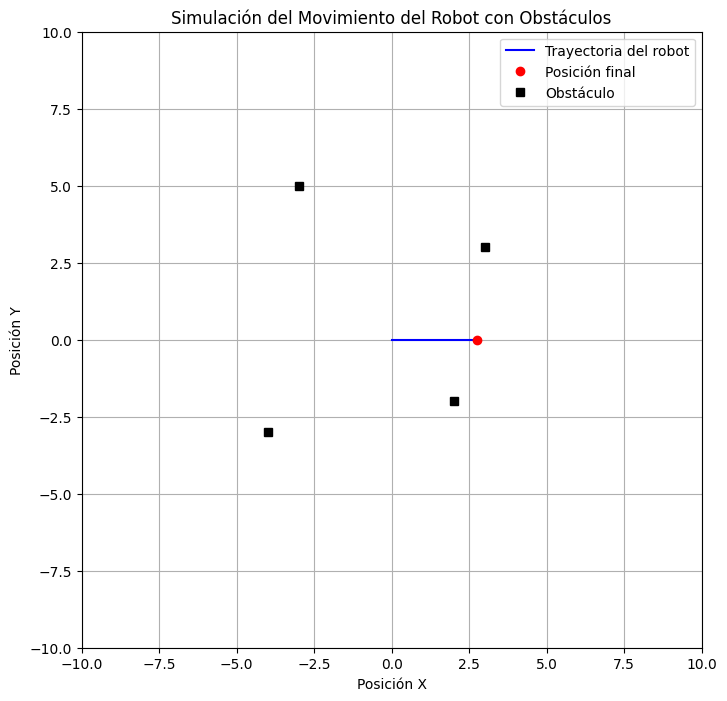

Simulación con Velocidad Lineal: 0.275, Velocidad Angular: 0.25


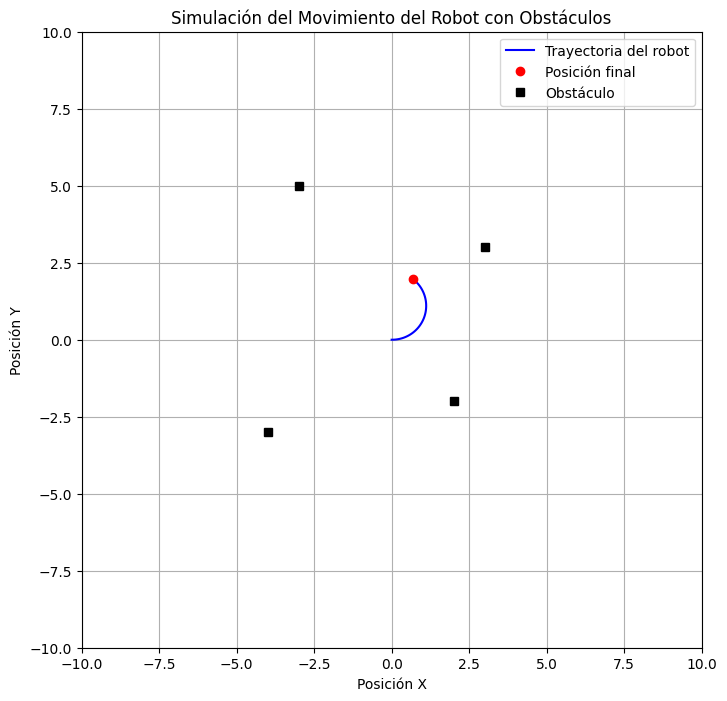

Simulación con Velocidad Lineal: 0.275, Velocidad Angular: 0.5


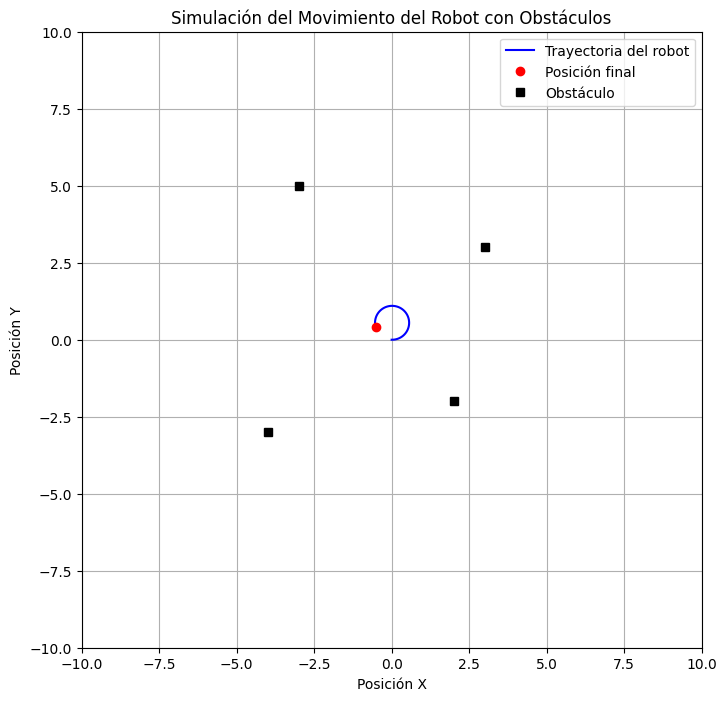

Simulación con Velocidad Lineal: 0.45000000000000007, Velocidad Angular: -0.5


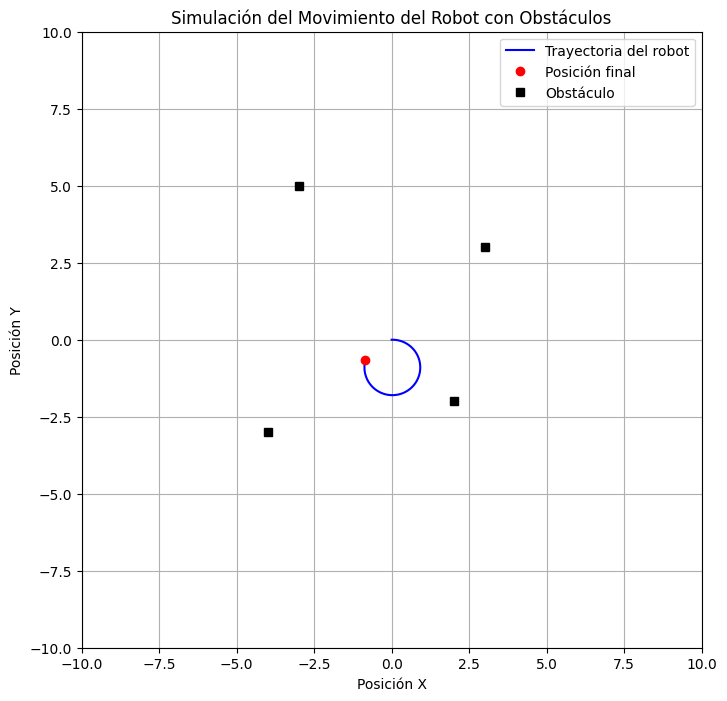

Simulación con Velocidad Lineal: 0.45000000000000007, Velocidad Angular: -0.25


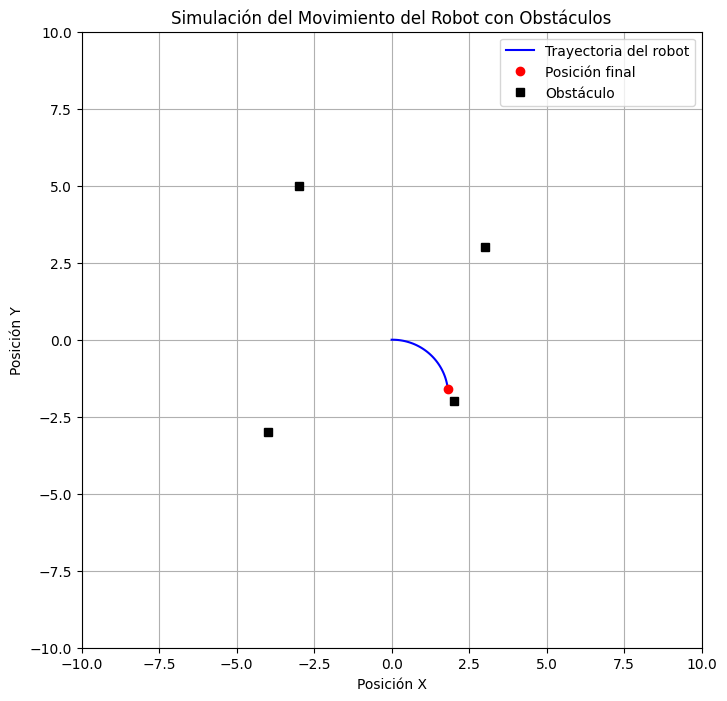

Simulación con Velocidad Lineal: 0.45000000000000007, Velocidad Angular: 0.0


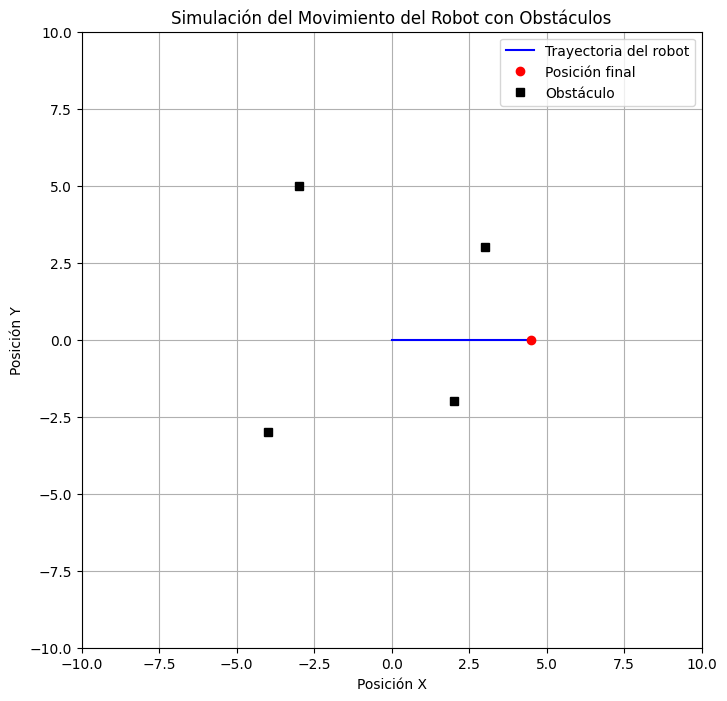

Simulación con Velocidad Lineal: 0.45000000000000007, Velocidad Angular: 0.25


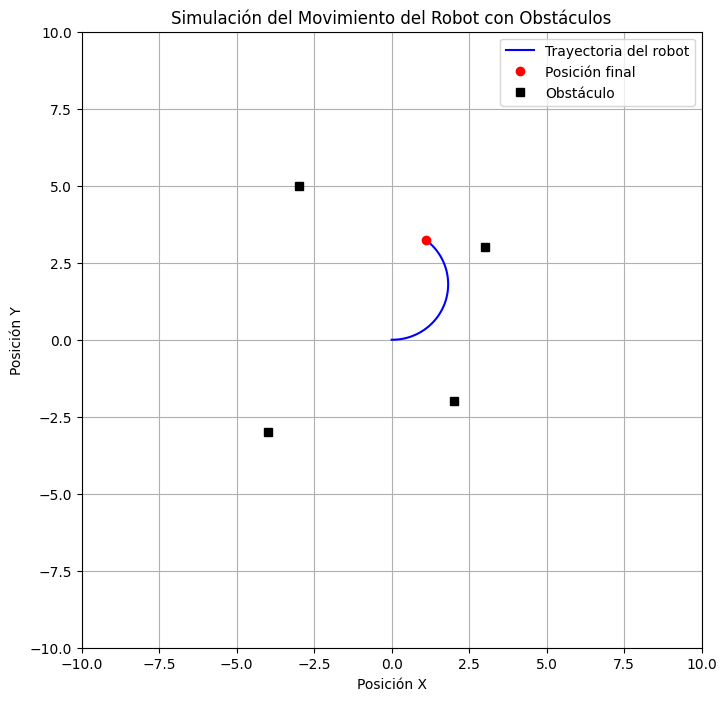

Simulación con Velocidad Lineal: 0.45000000000000007, Velocidad Angular: 0.5


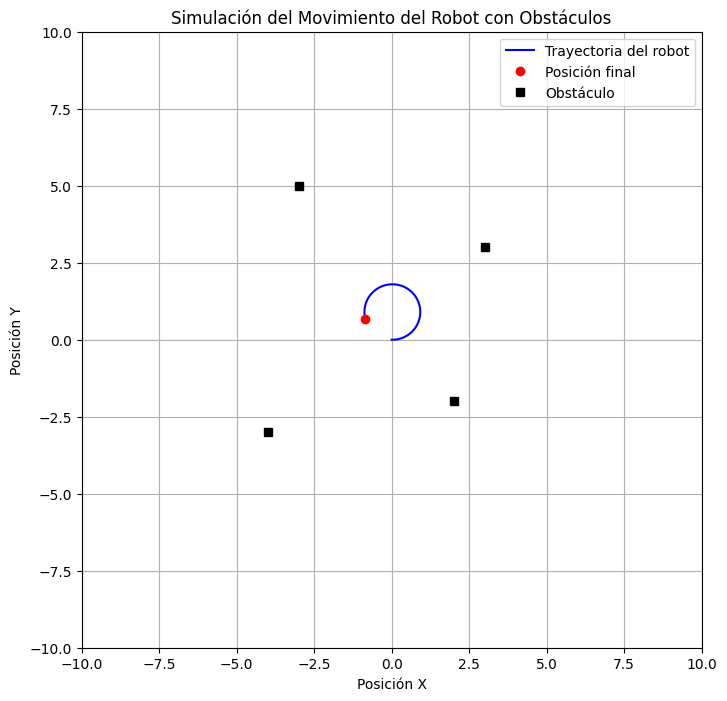

Simulación con Velocidad Lineal: 0.625, Velocidad Angular: -0.5


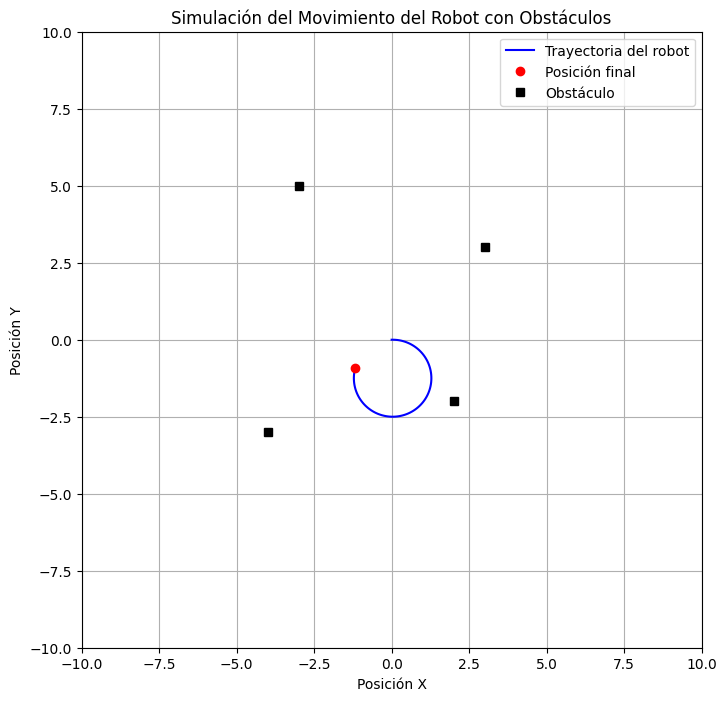

Simulación con Velocidad Lineal: 0.625, Velocidad Angular: -0.25


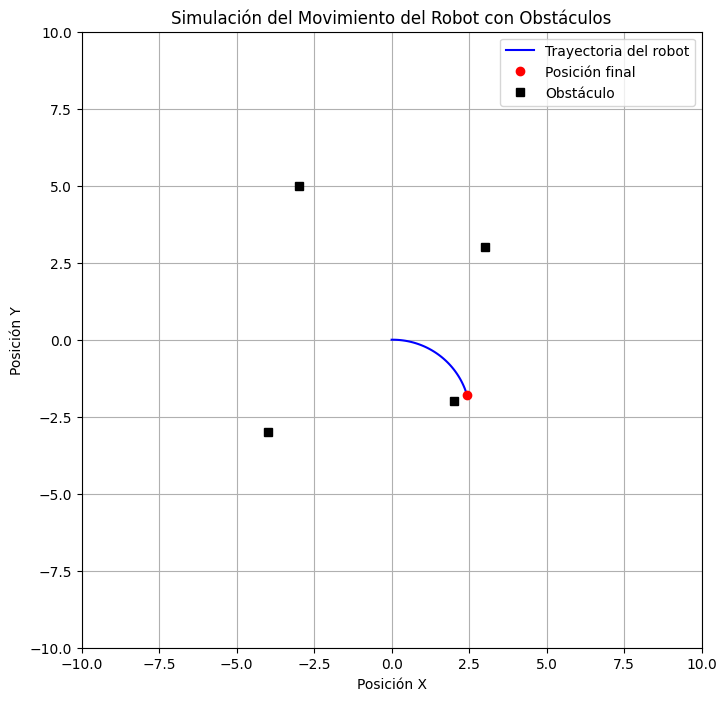

Simulación con Velocidad Lineal: 0.625, Velocidad Angular: 0.0


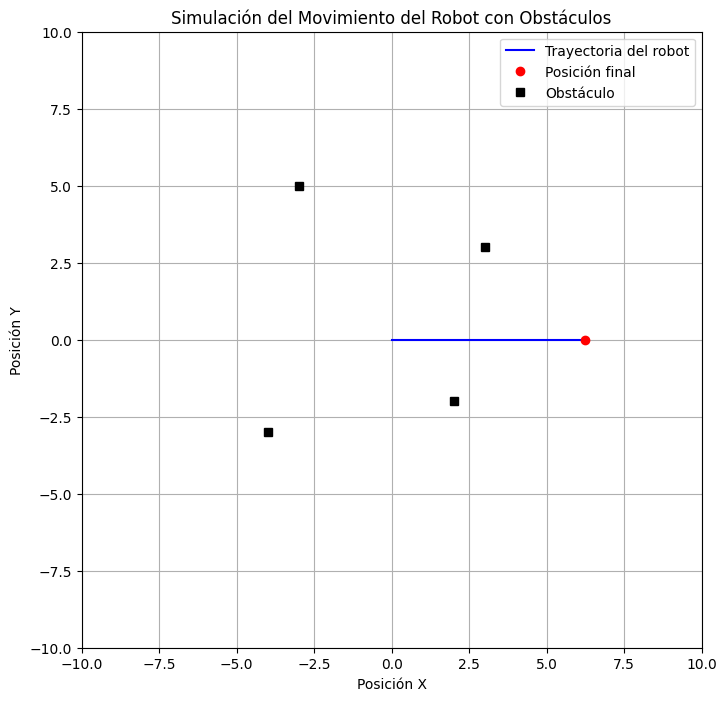

Simulación con Velocidad Lineal: 0.625, Velocidad Angular: 0.25


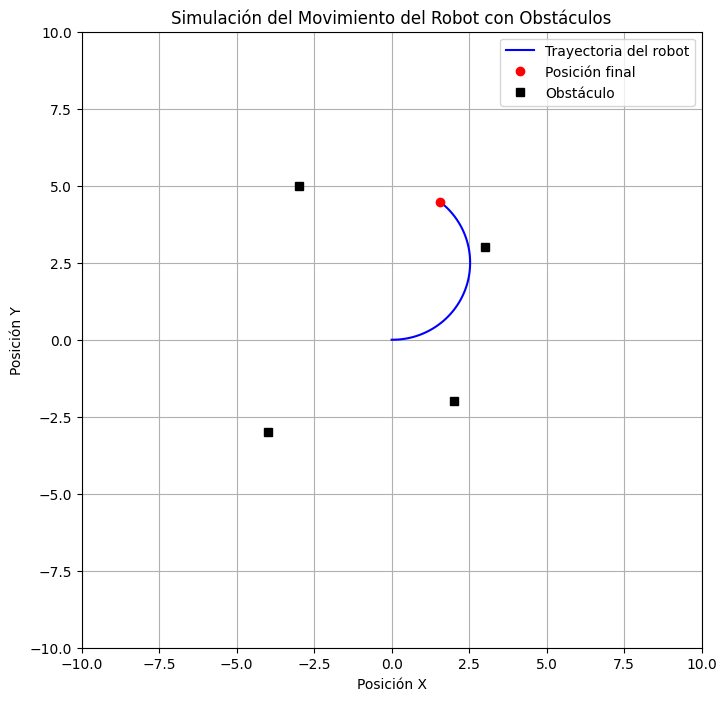

Simulación con Velocidad Lineal: 0.625, Velocidad Angular: 0.5


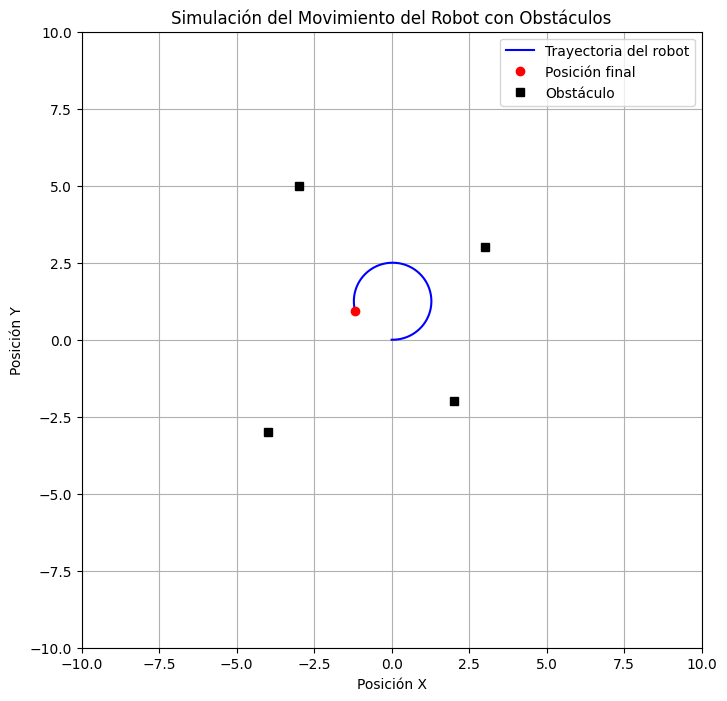

Simulación con Velocidad Lineal: 0.8, Velocidad Angular: -0.5


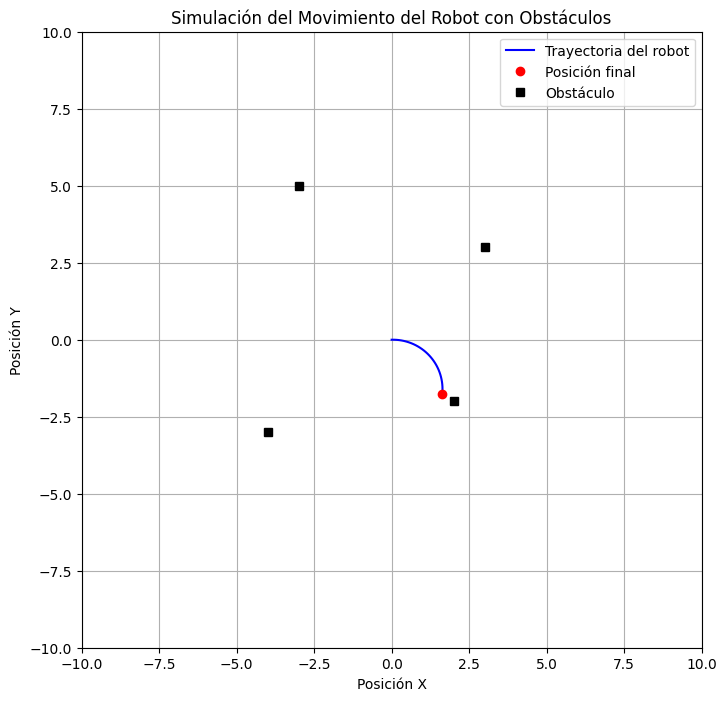

Simulación con Velocidad Lineal: 0.8, Velocidad Angular: -0.25


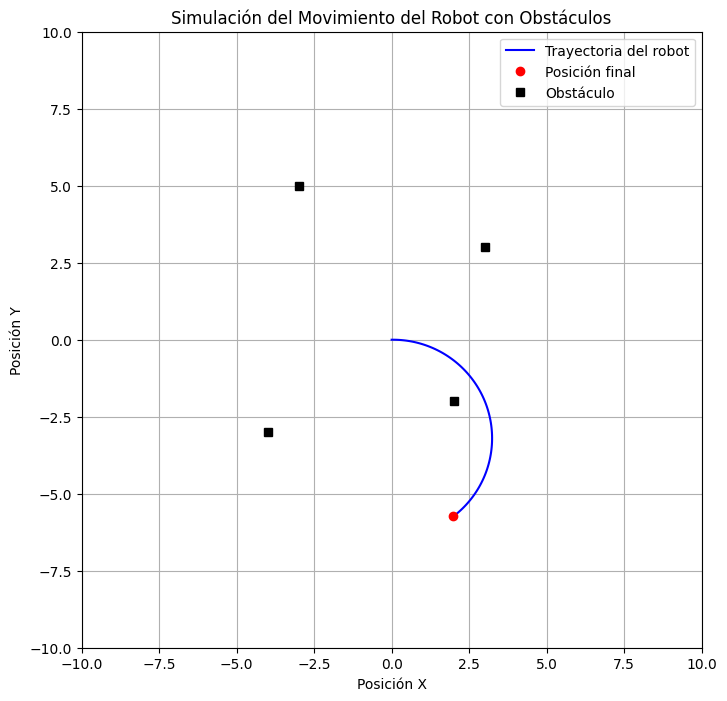

Simulación con Velocidad Lineal: 0.8, Velocidad Angular: 0.0


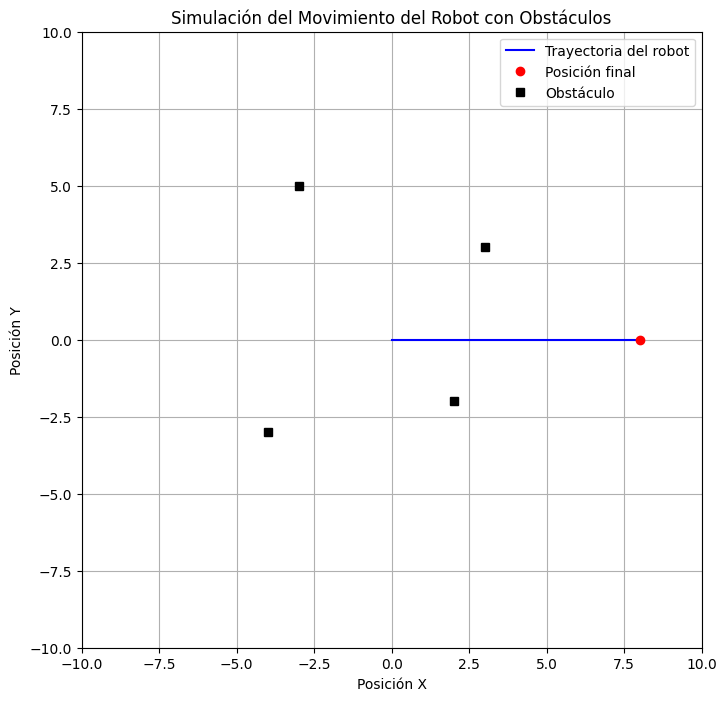

Simulación con Velocidad Lineal: 0.8, Velocidad Angular: 0.25


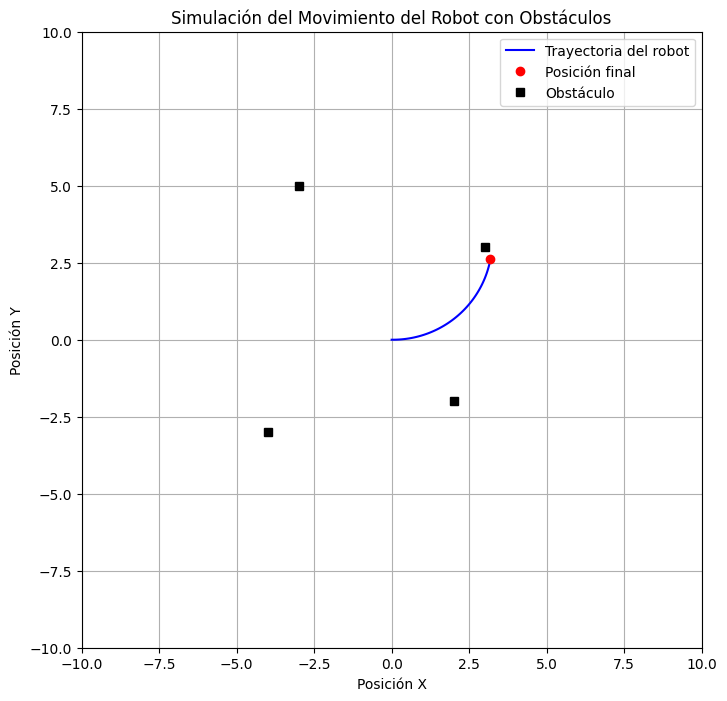

Simulación con Velocidad Lineal: 0.8, Velocidad Angular: 0.5


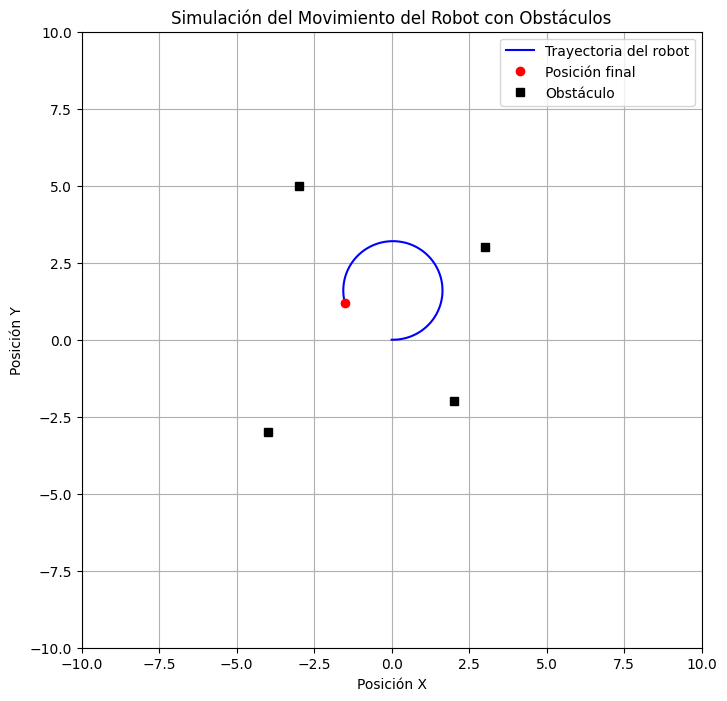

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz

# Parámetros del entorno
universe_s3 = np.arange(0, 401, 1)
universe_s4 = np.arange(0, 401, 1)
universe_diff_esquineros = np.arange(-200, 201, 1)
universe_diff_laterales = np.arange(-200, 201, 1)

universe_linear_velocity = np.arange(0, 1.01, 0.01)
universe_angular_velocity = np.arange(-1, 1.01, 0.01)

# Funciones de membresía para las velocidades
vel_lineal_pp = fuzz.trimf(universe_linear_velocity, [0, 0, 0.25])
vel_lineal_pm = fuzz.trimf(universe_linear_velocity, [0, 0.25, 0.5])
vel_lineal_m  = fuzz.trimf(universe_linear_velocity, [0.25, 0.5, 0.75])
vel_lineal_gm = fuzz.trimf(universe_linear_velocity, [0.5, 0.75, 1])
vel_lineal_gg = fuzz.trimf(universe_linear_velocity, [0.75, 1, 1])

fuzzy_vel_lineal = [vel_lineal_pp, vel_lineal_pm, vel_lineal_m, vel_lineal_gm, vel_lineal_gg]

# Funciones de membresía para las velocidades angulares
vel_angular_n  = fuzz.trimf(universe_angular_velocity, [-1, -1, -0.2])
vel_angular_nm = fuzz.trimf(universe_angular_velocity, [-0.6, -0.45, 0])
vel_angular_z  = fuzz.trimf(universe_angular_velocity, [-0.4, 0, 0.4])
vel_angular_p  = fuzz.trimf(universe_angular_velocity, [0.2, 1, 1.01])

fuzzy_vel_angular = [vel_angular_n, vel_angular_nm, vel_angular_z, vel_angular_p]

# Simulación del movimiento del robot
def actualizar_posicion(x, y, theta, v_lineal, v_angular, dt=0.1):
    """
    Actualiza la posición y orientación del robot basado en las velocidades lineales y angulares.
    """
    x_new = x + v_lineal * np.cos(theta) * dt
    y_new = y + v_lineal * np.sin(theta) * dt
    theta_new = theta + v_angular * dt
    return x_new, y_new, theta_new

# Función para comprobar si hay colisiones con obstáculos
def detectar_colision(x, y, obstaculos, umbral=0.5):
    """
    Detecta si el robot está cerca de un obstáculo.
    x, y: Posición actual del robot
    obstaculos: Lista de obstáculos (tuplas con coordenadas x, y)
    umbral: Distancia mínima a un obstáculo para evitar colisión
    """
    for (ox, oy) in obstaculos:
        distancia = np.sqrt((x - ox)**2 + (y - oy)**2)
        if distancia < umbral:
            return True
    return False

# Simulación de movimiento con obstáculos
def simular_movimiento_con_obstaculos(centroid_lineal, centroid_angular, obstaculos, pasos=100):
    # Posición inicial del robot
    x, y, theta = 0, 0, 0  # Posición (x, y) y orientación (theta)

    # Listas para almacenar la trayectoria
    trayectoria_x = [x]
    trayectoria_y = [y]

    # Simulación
    for _ in range(pasos):
        # Si el robot detecta una colisión, reducimos la velocidad o cambiamos la dirección
        if detectar_colision(x, y, obstaculos):
            centroid_lineal *= 0.5  # Reducir la velocidad lineal
            centroid_angular *= -1  # Cambiar la dirección angular

        x, y, theta = actualizar_posicion(x, y, theta, centroid_lineal, centroid_angular)
        trayectoria_x.append(x)
        trayectoria_y.append(y)

    # Visualizar el movimiento y los obstáculos
    plt.figure(figsize=(8, 8))

    # Dibujar la trayectoria del robot
    plt.plot(trayectoria_x, trayectoria_y, 'b-', label="Trayectoria del robot")
    plt.plot(trayectoria_x[-1], trayectoria_y[-1], 'ro', label="Posición final")

    # Dibujar los obstáculos
    for (ox, oy) in obstaculos:
        plt.plot(ox, oy, 'ks', label="Obstáculo" if ox == obstaculos[0][0] else "")  # Obstáculos en negro

    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.grid(True)
    plt.xlabel("Posición X")
    plt.ylabel("Posición Y")
    plt.title("Simulación del Movimiento del Robot con Obstáculos")
    plt.legend()
    plt.show()

# Definir un rango de velocidades para probar
velocidades_lineales = np.linspace(0.1, 0.8, 5)  # Un rango de velocidades lineales
velocidades_angulares = np.linspace(-0.5, 0.5, 5)  # Un rango de velocidades angulares

# Definir los obstáculos en el espacio 2D
obstaculos = [(3, 3), (-4, -3), (2, -2), (-3, 5)]  # Coordenadas (x, y) de los obstáculos

# Probar las combinaciones de velocidades lineales y angulares
for v_lineal in velocidades_lineales:
    for v_angular in velocidades_angulares:
        print(f"Simulación con Velocidad Lineal: {v_lineal}, Velocidad Angular: {v_angular}")
        simular_movimiento_con_obstaculos(v_lineal, v_angular, obstaculos)


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import skfuzzy as fuzz

# Parámetros del entorno
universe_s3 = np.arange(0, 401, 1)
universe_s4 = np.arange(0, 401, 1)
universe_diff_esquineros = np.arange(-200, 201, 1)
universe_diff_laterales = np.arange(-200, 201, 1)

universe_linear_velocity = np.arange(0, 1.01, 0.01)
universe_angular_velocity = np.arange(-1, 1.01, 0.01)

# Funciones de membresía para las velocidades
vel_lineal_pp = fuzz.trimf(universe_linear_velocity, [0, 0, 0.25])
vel_lineal_pm = fuzz.trimf(universe_linear_velocity, [0, 0.25, 0.5])
vel_lineal_m  = fuzz.trimf(universe_linear_velocity, [0.25, 0.5, 0.75])
vel_lineal_gm = fuzz.trimf(universe_linear_velocity, [0.5, 0.75, 1])
vel_lineal_gg = fuzz.trimf(universe_linear_velocity, [0.75, 1, 1])

fuzzy_vel_lineal = [vel_lineal_pp, vel_lineal_pm, vel_lineal_m, vel_lineal_gm, vel_lineal_gg]

# Funciones de membresía para las velocidades angulares
vel_angular_n  = fuzz.trimf(universe_angular_velocity, [-1, -1, -0.2])
vel_angular_nm = fuzz.trimf(universe_angular_velocity, [-0.6, -0.45, 0])
vel_angular_z  = fuzz.trimf(universe_angular_velocity, [-0.4, 0, 0.4])
vel_angular_p  = fuzz.trimf(universe_angular_velocity, [0.2, 1, 1.01])

fuzzy_vel_angular = [vel_angular_n, vel_angular_nm, vel_angular_z, vel_angular_p]

# Simulación del movimiento del robot
def actualizar_posicion(x, y, theta, v_lineal, v_angular, dt=0.1):
    """
    Actualiza la posición y orientación del robot basado en las velocidades lineales y angulares.
    """
    x_new = x + v_lineal * np.cos(theta) * dt
    y_new = y + v_lineal * np.sin(theta) * dt
    theta_new = theta + v_angular * dt
    return x_new, y_new, theta_new

# Función para comprobar si hay colisiones con obstáculos
def detectar_colision(x, y, obstaculos, umbral=0.5):
    """
    Detecta si el robot está cerca de un obstáculo.
    x, y: Posición actual del robot
    obstaculos: Lista de obstáculos (tuplas con coordenadas x, y)
    umbral: Distancia mínima a un obstáculo para evitar colisión
    """
    for (ox, oy) in obstaculos:
        distancia = np.sqrt((x - ox)**2 + (y - oy)**2)
        if distancia < umbral:
            return True
    return False

# Simulación de movimiento con obstáculos y gráfica 3D
def simular_movimiento_3d(centroid_lineal, centroid_angular, obstaculos, pasos=100):
    # Posición inicial del robot
    x, y, theta = 0, 0, 0  # Posición (x, y) y orientación (theta)

    # Listas para almacenar la trayectoria
    trayectoria_x = [x]
    trayectoria_y = [y]
    trayectoria_theta = [theta]

    # Simulación
    for _ in range(pasos):
        # Si el robot detecta una colisión, reducimos la velocidad o cambiamos la dirección
        if detectar_colision(x, y, obstaculos):
            centroid_lineal *= 0.5  # Reducir la velocidad lineal
            centroid_angular *= -1  # Cambiar la dirección angular

        x, y, theta = actualizar_posicion(x, y, theta, centroid_lineal, centroid_angular)
        trayectoria_x.append(x)
        trayectoria_y.append(y)
        trayectoria_theta.append(theta)

    # Visualizar el movimiento en 3D
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Dibujar la trayectoria del robot
    ax.plot(trayectoria_x, trayectoria_y, trayectoria_theta, 'b-', label="Trayectoria del robot")
    ax.scatter(trayectoria_x[-1], trayectoria_y[-1], trayectoria_theta[-1], color='red', label="Posición final")

    # Dibujar los obstáculos en 3D
    for (ox, oy) in obstaculos:
        ax.scatter(ox, oy, 0, color='black', s=100, label="Obstáculo" if (ox, oy) == obstaculos[0] else "")

    ax.set_xlim([-10, 10])
    ax.set_ylim([-10, 10])
    ax.set_zlim([-np.pi, np.pi])
    ax.set_xlabel("Posición X")
    ax.set_ylabel("Posición Y")
    ax.set_zlabel("Orientación (Theta)")
    ax.set_title("Simulación 3D del Movimiento del Robot con Obstáculos")
    ax.legend()

    plt.show()

# Definir un rango de velocidades para probar
velocidades_lineales = np.linspace(0.1, 0.8, 5)  # Un rango de velocidades lineales
velocidades_angulares = np.linspace(-0.5, 0.5, 5)  # Un rango de velocidades angulares

# Definir los obstáculos en el espacio 2D
obstaculos = [(3, 3), (-4, -3), (2, -2), (-3, 5)]  # Coordenadas (x, y) de los obstáculos

# Probar las combinaciones de velocidades lineales y angulares
for v_lineal in velocidades_lineales:
    for v_angular in velocidades_angulares:
        print(f"Simulación con Velocidad Lineal: {v_lineal}, Velocidad Angular: {v_angular}")
        simular_movimiento_3d(v_lineal, v_angular, obstaculos)


Output hidden; open in https://colab.research.google.com to view.